# Structural Causal Models for Compensation Analysis

In today's job market, compensation analysis is critical for both employers and job seekers. This study leverages causal modeling techniques to explore not only the determinants of salary but also engagement rates in the job market. The objective is to provide actionable insights for both employers and job seekers:

- For Employers: Identify structural factors that contribute to pay disparities and develop equitable compensation policies that enhance talent retention without reducing competitiveness.

- For Job Seekers: Understand how job roles and skill requirements influence salary offers and hiring trends to inform career optimization strategies.

By applying Structural Causal Models (SCMs), we aim to uncover the underlying mechanisms driving compensation trends, highlight market dynamics, and assess interventions—such as remote work—that could mitigate systemic disparities or improve hiring outcomes.

#### Data Acquisition

The dataset utilized for this study is sourced from Kaggle’s LinkedIn Job Postings dataset (https://www.kaggle.com/datasets/arshkon/linkedin-job-postings), which is updated monthly. The dataset includes job postings with attributes such as:

- Job Title, Industry, and Function
- Location and Benefit Indicators (Remote work...)
- Company Size and Type
- Skill Requirements & Years of Experience

#### Data Cleaning & Feature Engineering

Several preprocessing steps were conducted to ensure data consistency and usability:

- Re-classification: Dimension reduction.
- Categorical Encoding: Features such as job function and company type were one-hot encoded.
- Compensation Normalization: Salaries were adjusted to a standardized scale (e.g., annualized if given in different timeframes).
- Creating New Variables: Additional features, such as a remote work indicator and industry growth rate, were generated to enrich the causal analysis.
- Outlier Treatment: To ensure analysis quality, extreme-right skewed data was trimmed, and log transformations were applied where necessary.

#### Experimental Design

- Benefit Model: Examines the impact of benefits (remote work...) on salary and job posting engagement.
- Experience Level Model: Investigates how experience levels mediate salary disparities across job functions.

## Causal Discovery (EDA) & Data Structure Understanding

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

path = os.getcwd()
os.chdir(path)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Inspect the cleaned data from Felix.

In [2]:
# load data
df = pd.read_csv("Final_DataFrame.csv")
print(df.shape)
print(df.describe(include = "all"))
df.head()

(39958, 58)
              job_id   industry_id     salary_id currency_x  \
count   3.995800e+04  39958.000000  39958.000000      39958   
unique           NaN           NaN           NaN          5   
top              NaN           NaN           NaN        USD   
freq             NaN           NaN           NaN      39940   
mean    3.897016e+09    216.667351  20715.031058        NaN   
std     7.272430e+07    610.896958  11563.604553        NaN   
min     9.217160e+05      1.000000      3.000000        NaN   
25%     3.895221e+09     17.000000  10974.000000        NaN   
50%     3.901990e+09     45.000000  20762.000000        NaN   
75%     3.904578e+09     96.000000  30418.500000        NaN   
max     3.906267e+09   3253.000000  40785.000000        NaN   

       compensation_type_x    company_name              title  \
count                39958           39958              39958   
unique                   1            9062              20084   
top            BASE_SALARY  Insight 

job_id  industry_id  salary_id currency_x compensation_type_x  \
0  3884431523           56        3.0        USD         BASE_SALARY   
1  3884911725           12        4.0        USD         BASE_SALARY   
2  3884911725           17        4.0        USD         BASE_SALARY   
3  3884911725           15        4.0        USD         BASE_SALARY   
4  3887473220           43        5.0        USD         BASE_SALARY   

                   company_name  \
0              Energy Fuels Inc   
1  Direct Sales Recruiting, LLC   
2  Direct Sales Recruiting, LLC   
3  Direct Sales Recruiting, LLC   
4            Motion Recruitment   

                                           title  \
0                                   Mine Foreman   
1  Territory Sales - Medical Sales - Long Island   
2  Territory Sales - Medical Sales - Long Island   
3  Territory Sales - Medical Sales - Long Island   
4                                Project Manager   

                                       description_x                 location  \
0  GENERAL PURPOSE:Under the general direction of...   Greater Flagstaff Area   
1  Territory Sales Manager - Medical Sales\nMy cl...            Hempstead, NY   
2  Territory Sales Manager - Medical Sales\nMy cl...            Hempstead, NY   
3  Territory Sales Manager - Medical Sales\nMy cl...            Hempstead, NY   
4  Our client, a financial services company, is l...  New York, United States   

   company_id  views formatted_work_type  applies  remote_allowed  \
0    947812.0    4.0           Full-time      0.0             0.0   
1    766849.0    4.0           Full-time      1.0             0.0   
2    766849.0    4.0           Full-time      1.0             0.0   
3    766849.0    4.0           Full-time      1.0             0.0   
4      5887.0    8.0            Contract      1.0             0.0   

                                     job_posting_url    application_type  \
0  https://www.linkedin.com/jobs/view/3884431523/...  ComplexOnsiteApply   
1  https://www.linkedin.com/jobs/view/3884911725/...   SimpleOnsiteApply   
2  https://www.linkedin.com/jobs/view/3884911725/...   SimpleOnsiteApply   
3  https://www.linkedin.com/jobs/view/3884911725/...   SimpleOnsiteApply   
4  https://www.linkedin.com/jobs/view/3887473220/...  ComplexOnsiteApply   

  formatted_experience_level  sponsored  work_type compensation_type_y  \
0           Mid-Senior level        0.0  FULL_TIME         BASE_SALARY   
1                  Associate        0.0  FULL_TIME         BASE_SALARY   
2                  Associate        0.0  FULL_TIME         BASE_SALARY   
3                  Associate        0.0  FULL_TIME         BASE_SALARY   
4                  Associate        0.0   CONTRACT         BASE_SALARY   

   normalized_salary  employee_count  follower_count  \
0           110000.0      102.000000     2831.000000   
1           105000.0       24.500000    68099.500000   
2           105000.0       24.500000    68099.500000   
3           105000.0       24.500000    68099.500000   
4            70720.0     1425.166667   982403.666667   

                                       description_y  company_size     state  \
0  Energy Fuels (NYSE MKT UUUU | TSX:EFR) is a le...           2.0  Colorado   
1  Direct Sales Recruiting, LLC, where we bring m...           1.0        NJ   
2  Direct Sales Recruiting, LLC, where we bring m...           1.0        NJ   
3  Direct Sales Recruiting, LLC, where we bring m...           1.0        NJ   
4  Motion Recruitment delivers IT Talent Solution...           4.0        MA   

  country           city zip_code_y            address  \
0      US       Lakewood      80228    225 Union Blvd.   
1      US  Basking Ridge       7920                  0   
2      US  Basking Ridge       7920                  0   
3      US  Basking Ridge       7920                  0   
4      US         Boston       2116  131 Clarendon St.   

                                                 url                 industry  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39958 entries, 0 to 39957
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      39958 non-null  int64  
 1   industry_id                 39958 non-null  int64  
 2   salary_id                   39958 non-null  float64
 3   currency_x                  39958 non-null  object 
 4   compensation_type_x         39958 non-null  object 
 5   company_name                39958 non-null  object 
 6   title                       39958 non-null  object 
 7   description_x               39958 non-null  object 
 8   location                    39958 non-null  object 
 9   company_id                  39958 non-null  float64
 10  views                       39958 non-null  float64
 11  formatted_work_type         39958 non-null  object 
 12  applies                     39958 non-null  float64
 13  remote_allowed              399

- extracted_skills, combined_features should be lists
- convert Date and Time from object to DateTime

In [4]:
df.columns

Index(['job_id', 'industry_id', 'salary_id', 'currency_x',
       'compensation_type_x', 'company_name', 'title', 'description_x',
       'location', 'company_id', 'views', 'formatted_work_type', 'applies',
       'remote_allowed', 'job_posting_url', 'application_type',
       'formatted_experience_level', 'sponsored', 'work_type',
       'compensation_type_y', 'normalized_salary', 'employee_count',
       'follower_count', 'description_y', 'company_size', 'state', 'country',
       'city', 'zip_code_y', 'address', 'url', 'industry', 'max_salary_in_usd',
       'min_salary_in_usd', 'max_hourly_salary_in_usd',
       'min_hourly_salary_in_usd', 'ListedDate', 'ListedTime', 'ExpieryDate',
       'ExpieryTime', '401(k)', 'Child care support', 'Commuter benefits',
       'Dental insurance', 'Disability insurance', 'Medical insurance',
       'Paid maternity leave', 'Paid paternity leave', 'Pension plan',
       'Student loan assistance', 'Tuition assistance', 'Vision insurance',
       'Com

In [5]:
len(df[df["compensation_type_x"] != df["compensation_type_y"]])

0

*** If the relationship between job & salary is 1-1 or if some jobs have multiple salaries, we need to consider whether averaging multiple salaries is appropriate.

In [6]:
# double confirm no duplicates
print(df.duplicated().any())

print(len(df["salary_id"].unique())) # salaries appear multiple times
print(len(df["industry_id"].unique())) # so do industries
print(len(df["job_id"].unique())) # and jobs
print(len(df["company_id"].unique())) # and companies
print(len(df[["job_id", "salary_id"]].drop_duplicates())) # each job is paired with only one salary
print(len(df[["job_id", "salary_id", "industry_id"]].drop_duplicates())) # job-salary pairs appear multiple times is that they belong to different industries

False
29040
378
29040
9070
29040
39958


To avoid overwhelming, remove columns that won't be used any more after the cleaning

- ID related columns: since we now know each row represent one instance, id is useless for later analysis.
- currency: all money units has been transform into USD
- compensation_type: x and y are identical, drop one of them
- title: has been reduced to "TitleClean"
- work_type: keep formatted_work_type
- job_posting_url, url
- sponsored: a constant
- description columns: extracted_skills has been created
- address

combined_features 
- The first 50 numbers capture word importance via TF-IDF.
- The last N numbers indicate the presence of specific skills. (extracted_skills)

--> for causal ML and inference, extracted_skills is even better as it's interpretable

--> we also need to expand each skill into a separate row

In [7]:
rm_cols = ["job_id", "industry_id", "salary_id", "company_id", "currency_x", "compensation_type_y", "title", "work_type", "job_posting_url",
           "sponsored", "description_x", "description_y", "full_description", "cleaned_full_description", "url", "address", "combined_features"]

print("Before:", df.shape)
df.drop(columns=rm_cols, inplace=True, errors='ignore')
print(df.shape)

Before: (39958, 58)
(39958, 41)


In [8]:
import ast
from collections import Counter

# extracted_skills is a string instead of a list, first need to convert them
df['extracted_skills'] = df['extracted_skills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# flatten list of all skills
all_skills = df['extracted_skills'].explode()
skill_counts = Counter(all_skills)

top_skills = [skill for skill, _ in skill_counts.most_common(50)]
skill_count = {skill: df['extracted_skills'].apply(lambda x: skill in x).sum() for skill in top_skills}

skill_df = pd.DataFrame.from_dict(skill_count, orient='index', columns=['count'])
skill_df = skill_df.sort_values(by='count', ascending=False)

skill_df

count
information     22500
degree          20659
communication   20592
development     20532
environment     19620
disability      18866
employer        18727
technology      18194
training        15989
health          15945
salary          15866
education       15747
location        15225
state           14243
performance     14092
growth          13786
culture         13294
plan            13117
insurance       12957
need            12530
individual      11977
market          11224
law             11162
software        11115
engineering     10704
design          10454
value           10154
group           10030
application     10007
healthcare       9081
family           8987
equipment        7609
area             7609
marketing        7584
policy           7407
security         7183
member           7101
strategy         6616
account          6576
accounting       6374
hour             5404
practice         4892
responsibility   4401
patient          4317
resource         4289
construction     3934
operation        2893
qualification    1382
sale              821
datum               3

Most of the skills extracted are not actual job-related skills, many are generic words. They will not properly control for skills in causal models.

--> drop it!

In [9]:
df.drop(columns = "extracted_skills", inplace=True)
print(df.shape)

(39958, 40)


Hypothesis for day, time features:

- Job Posting Duration: Longer job postings might be associated with lower salaries like niche roles, unattractive compensation... (indicating difficulty in hiring).
- Seasonal Effects: Sararies could be influenced by holiday season or tax month --> Our data is updated monthly and only cover short period of time, so we don't have any variation in extracted Month, Quarter, Year from ListedDate. Namely, we don't have to control time effect.
- Day of the Week: Salaries are not time-sensitive in the short term, its effect on salary is inherently weak.

In [10]:
df['ListedDate'] = pd.to_datetime(df['ListedDate'])
df['ExpieryDate'] = pd.to_datetime(df['ExpieryDate'])
df['job_posting_duration'] = (df['ExpieryDate'] - df['ListedDate']).dt.days

df.drop(columns = ["ListedDate", "ExpieryDate", "ExpieryTime", "ListedTime"], inplace = True)

Identify variables with reasonable variation (ignore highly imbalanced ones).
1. The distribution of Numerical Variables

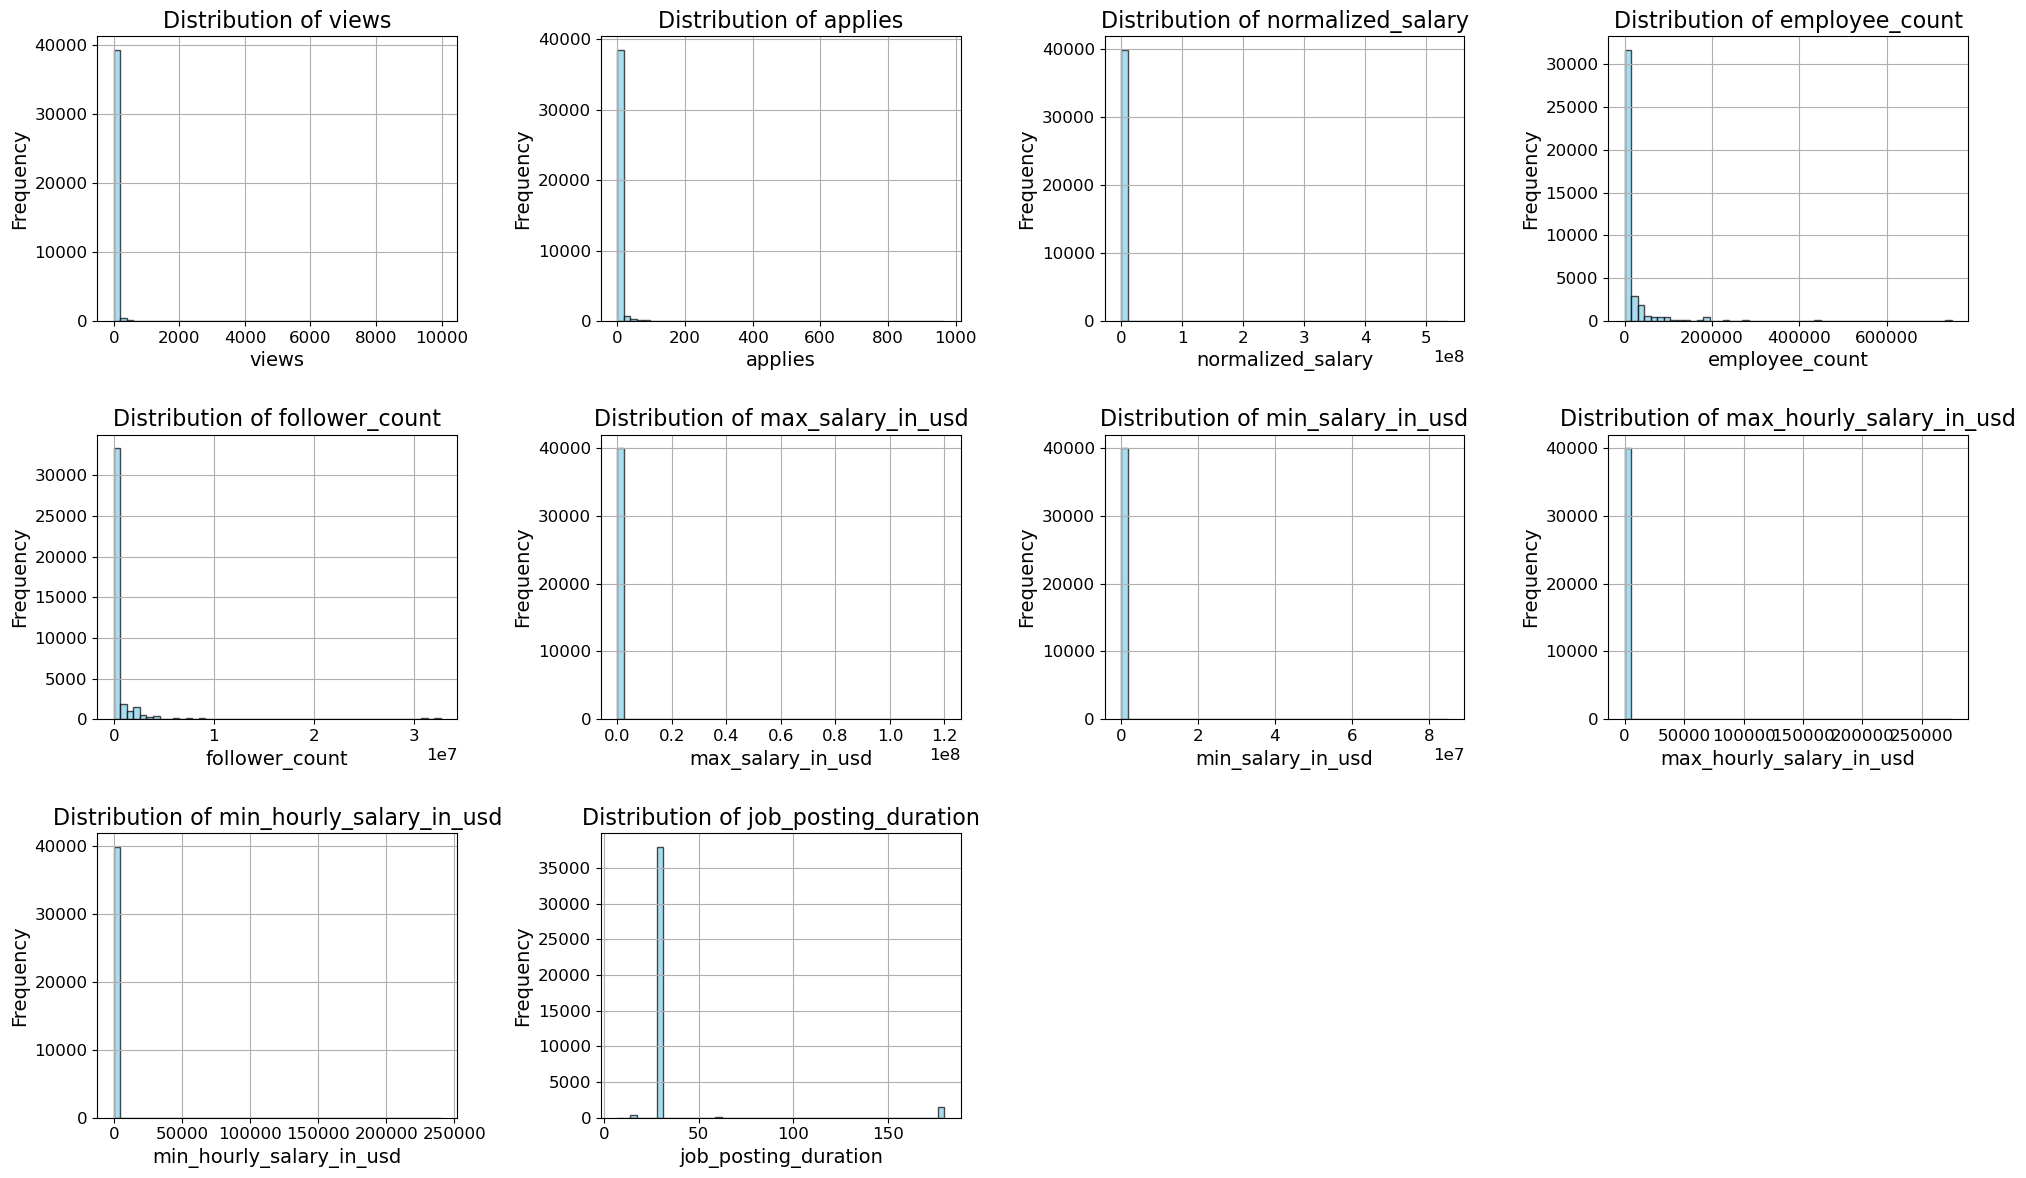

In [11]:
import math

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=16)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

numeric_columns = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 2 and col != "company_size"]

num_cols = len(numeric_columns)
num_rows = math.ceil(num_cols / 4)

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    df[col].hist(bins=50, ax=axes[i], alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [12]:
df[numeric_columns].describe()

views       applies  normalized_salary  employee_count  \
count  39958.000000  39958.000000       3.995800e+04    39958.000000   
mean      22.348966      3.343661       2.094125e+05    19091.821501   
std      143.611493     17.842649       4.933003e+06    62188.094500   
min        0.000000      0.000000       1.000000e+00        0.000000   
25%        3.000000      0.000000       6.150000e+04      129.000000   
50%        5.000000      0.000000       9.350000e+04     1310.500000   
75%       12.000000      1.000000       1.350000e+05    10787.000000   
max     9975.000000    967.000000       5.356000e+08   748029.500000   

       follower_count  max_salary_in_usd  min_salary_in_usd  \
count    3.995800e+04       3.995800e+04       3.995800e+04   
mean     7.936540e+05       9.545505e+04       6.731952e+04   
std      3.069282e+06       6.078191e+05       4.296933e+05   
min      0.000000e+00       1.000000e+00       1.000000e+00   
25%      1.449300e+04       5.200000e+01       4.000000e+01   
50%      7.310900e+04       8.500000e+04       6.500000e+04   
75%      3.579558e+05       1.450000e+05       1.000000e+05   
max      3.266054e+07       1.200000e+08       8.500000e+07   

       max_hourly_salary_in_usd  min_hourly_salary_in_usd  \
count              39958.000000              39958.000000   
mean                 113.535436                 87.819540   
std                 2579.935360               2166.873684   
min                    0.000481                  0.000481   
25%                   33.317308                 25.000000   
50%                   50.480769                 38.461538   
75%                   74.519231                 55.000000   
max               275000.000000             240000.000000   

       job_posting_duration  
count          39958.000000  
mean              35.485159  
std               28.365118  
min                7.000000  
25%               30.000000  
50%               30.000000  
75%               30.000000  
max              180.000000

In [13]:
# skewness coefficients
skewness_values = df[numeric_columns].skew(numeric_only=True)
skewed_features = skewness_values[abs(skewness_values) > 1]

print("Skewness for all numerical variables:")
print(skewness_values)

print("\n Absolute value > 1:")
print(skewed_features)

Skewness for all numerical variables:
views                        42.940849
applies                      16.472883
normalized_salary            66.411373
employee_count                7.258240
follower_count                8.035934
max_salary_in_usd           192.147910
min_salary_in_usd           193.280331
max_hourly_salary_in_usd     65.576166
min_hourly_salary_in_usd     67.537297
job_posting_duration          4.854704
dtype: float64

 Absolute value > 1:
views                        42.940849
applies                      16.472883
normalized_salary            66.411373
employee_count                7.258240
follower_count                8.035934
max_salary_in_usd           192.147910
min_salary_in_usd           193.280331
max_hourly_salary_in_usd     65.576166
min_hourly_salary_in_usd     67.537297
job_posting_duration          4.854704
dtype: float64


All variables are extremely right skewed, most values near 0 with a few extreme outliers. 

Detect Potential Causal Relationships - Check the correlation between salary and numerical variables.

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/2535629968.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  significance = p_values.applymap(lambda x: '***' if x < 0.001 else


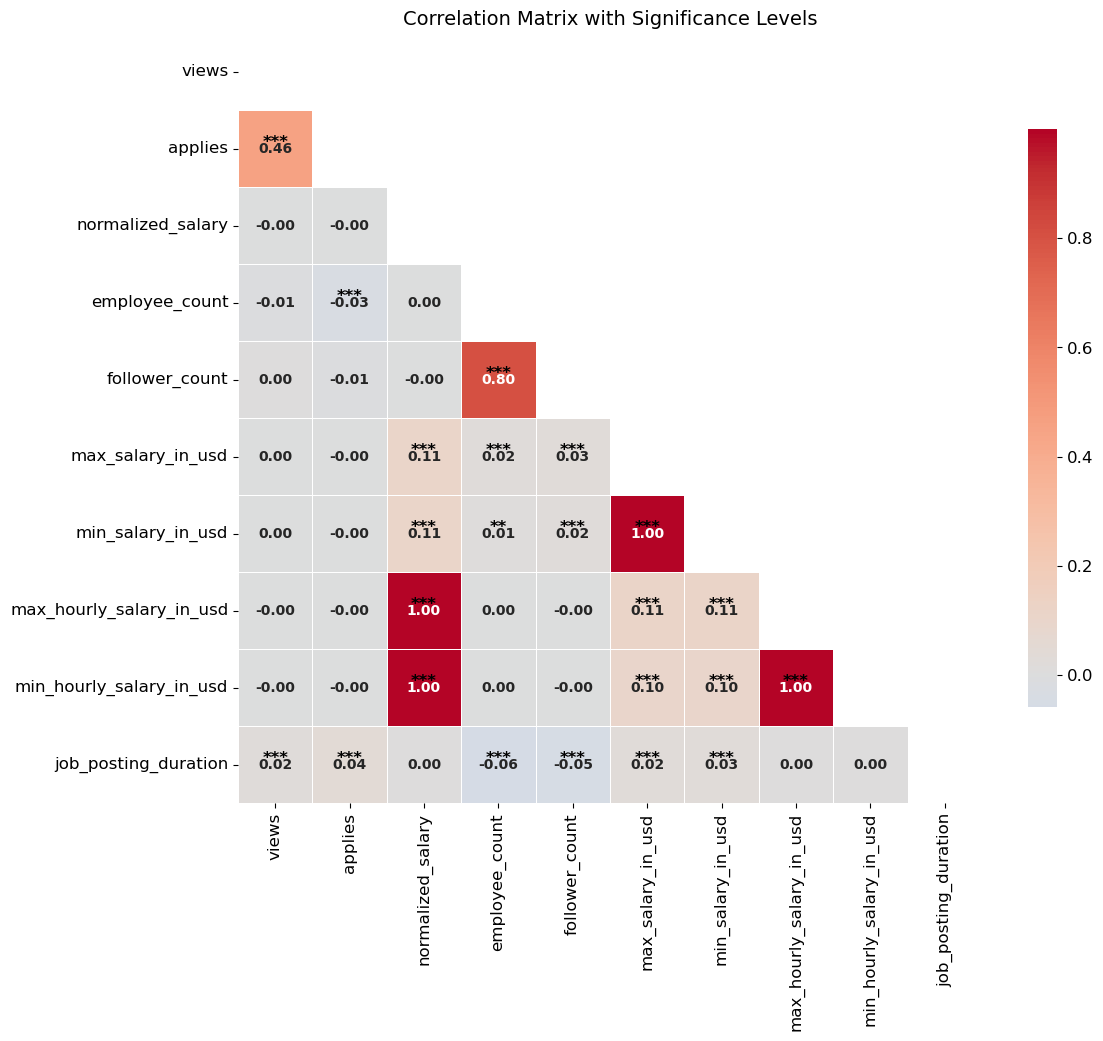

In [14]:
def corr_with_significance(df):
    corr = df.corr()
    p_values = pd.DataFrame(np.ones_like(corr), columns=df.columns, index=df.columns)

    for row in df.columns:
        for col in df.columns:
            if row != col:
                r, p = stats.pearsonr(df[row], df[col])
                corr.loc[row, col] = r
                p_values.loc[row, col] = p

    return corr, p_values

def plot_corr_with_significance(df):
    corr, p_values = corr_with_significance(df)

    significance = p_values.applymap(lambda x: '***' if x < 0.001 else
                                               '**' if x < 0.01 else
                                               '*' if x < 0.05 else
                                               '')

    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, ax=ax, 
                linewidths=0.5, mask=mask, cbar_kws={"shrink": 0.75},
                annot_kws={"size": 10, "weight": "bold"}) 

    for i in range(len(corr.columns)):
        for j in range(i):  # lower triangle only
            ax.text(j + 0.5, i + 0.42, significance.iloc[i, j],
                    color='black', ha='center', va='center', fontsize=12, fontweight='bold')

    plt.title("Correlation Matrix with Significance Levels", fontsize=14)
    plt.show()

plot_corr_with_significance(df[numeric_columns])

The correlation between Salary and other numerical variables are obscure, which may due to the data structure itself ! (skewness)
##### Skweness Correction

In causal machine learning, we need transformations that:
- Reduce extreme skewness (to avoid unstable estimates).
- Preserve interpretability (so causal effects make sense).
- Improve model performance (to ensure balanced treatment groups).

Apply transformations based on the level of skewness.
- For variables with extreme skewness (normalized_salary, max_salary_in_usd, min_salary_in_usd): apply Winsorization to cap (1%) unrealistic values + Log Transformation 
- For those with zero-inflation: Log Transformation (+1) considering interpretability.

after Log transformation, we can interpret the causal effect as:

"If salary is log-transformed, a 1-unit increase in XXX now represents a percentage change in salary instead of an absolute increase"

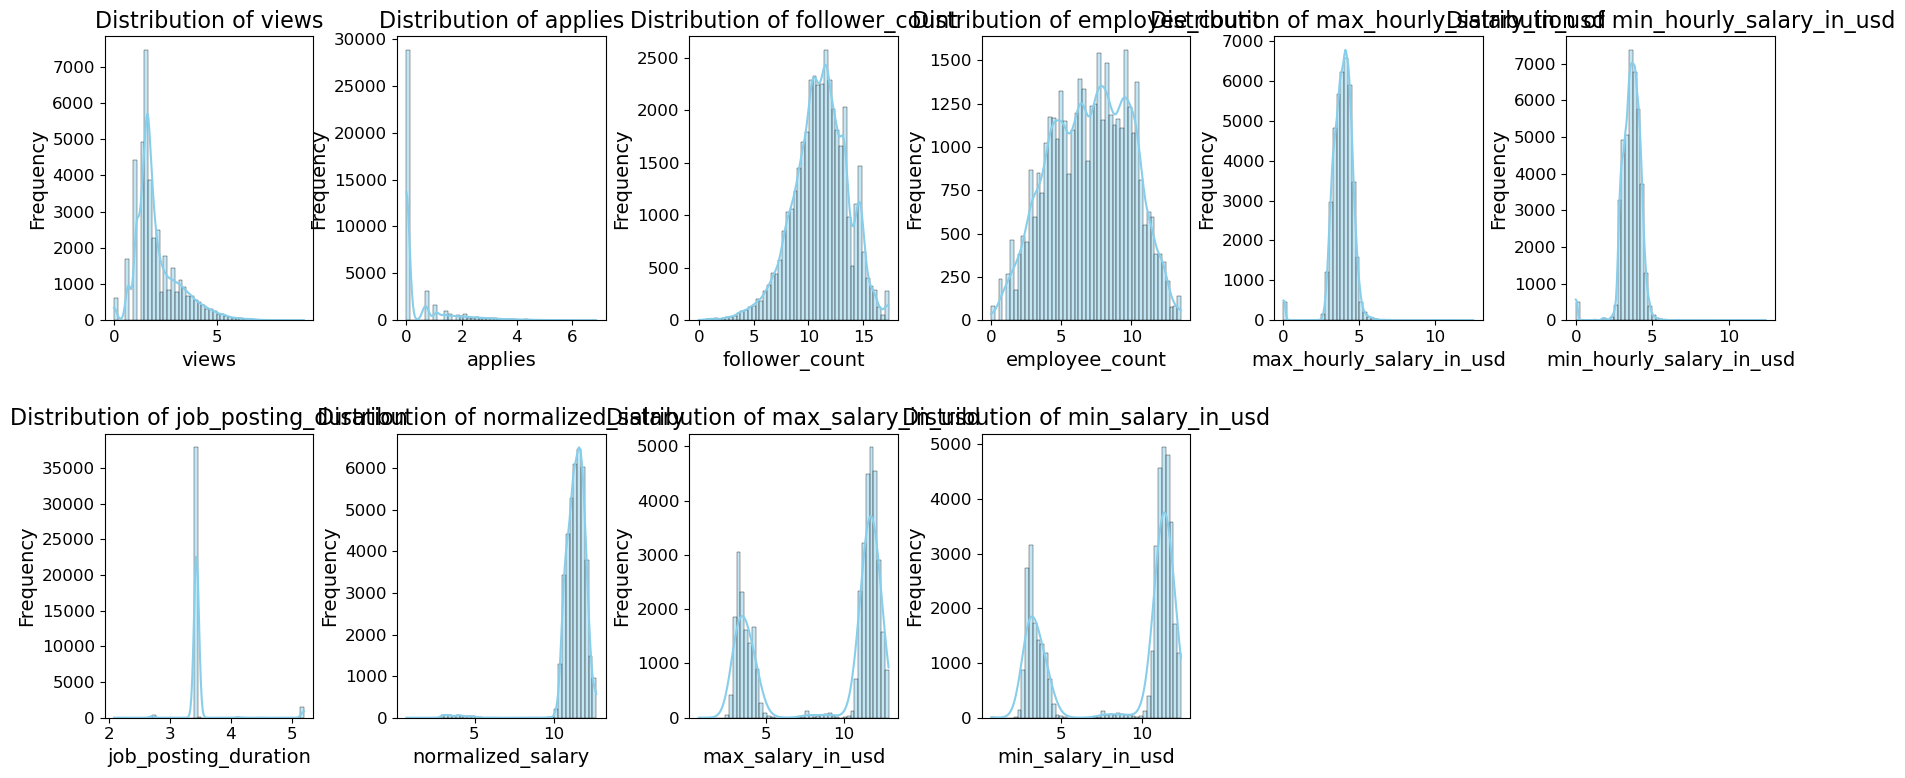

In [15]:
from scipy.stats.mstats import winsorize

df_transformed = df.copy()

winsor_cols = ["normalized_salary", "max_salary_in_usd", "min_salary_in_usd"]
for col in winsor_cols:
    df_transformed[col] = winsorize(df_transformed[col], limits=[0, 0.01])  # only trim down 1%

log_cols = ["views", "applies", "follower_count", "employee_count", "max_hourly_salary_in_usd", "min_hourly_salary_in_usd", 
            "job_posting_duration"] + winsor_cols

for col in log_cols:
    df_transformed[col] = np.log1p(df_transformed[col]) 

numeric_columns = log_cols  
num_vars = len(numeric_columns)

fig, axes = plt.subplots(nrows=2, ncols=(num_vars // 2) + 1, figsize=(18, 8))  
axes = axes.flatten() 

for i, col in enumerate(numeric_columns):
    sns.histplot(df_transformed[col], bins=50, ax=axes[i], kde=True, color='skyblue')
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j]) 

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

- max_salary_in_usd, min_salary_in_usd show bimodality, which suggests two distinct salary range groups exist. Where's the source of the difference from? industry? title?
- Job Posting Duration is Still Peaked

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/2535629968.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  significance = p_values.applymap(lambda x: '***' if x < 0.001 else


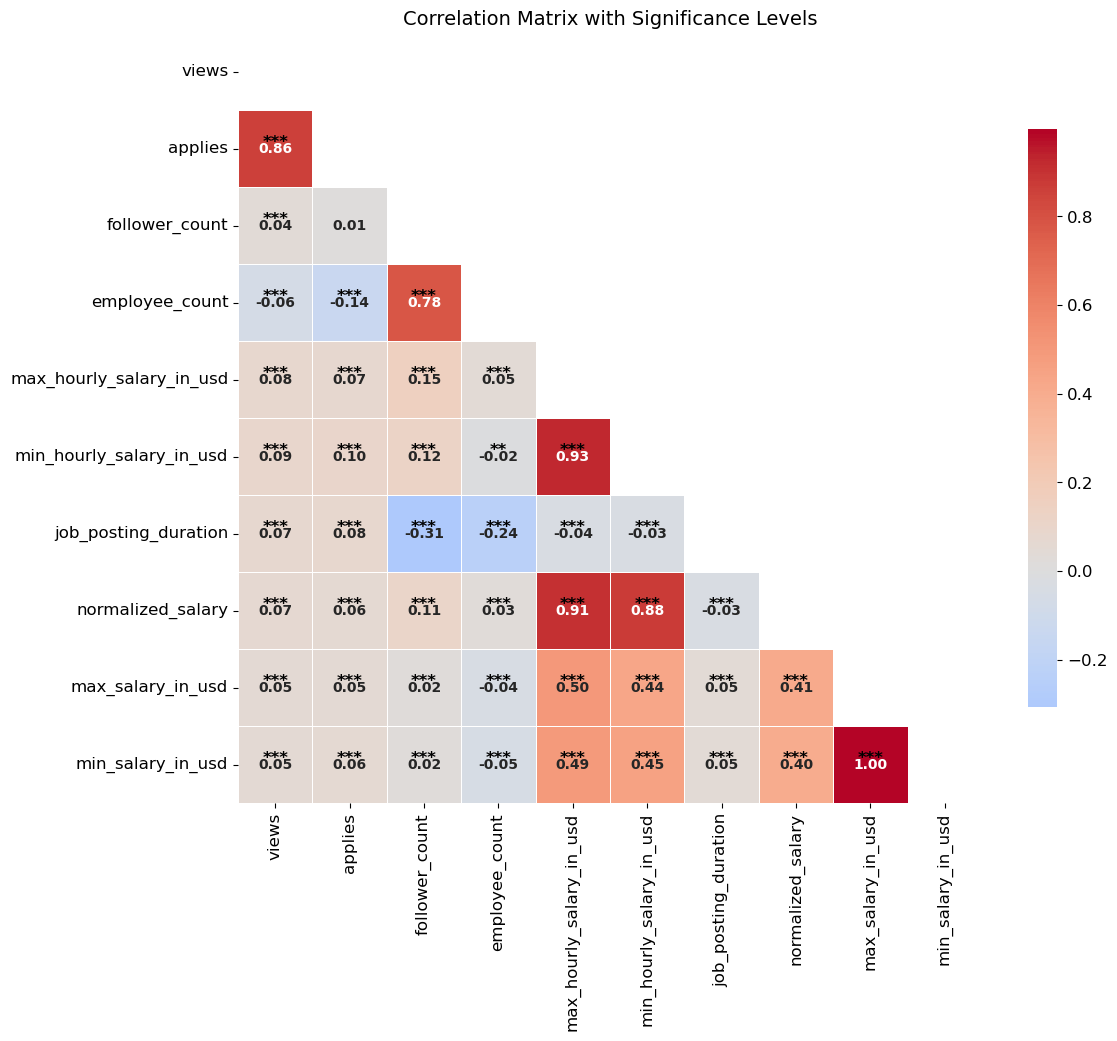

In [16]:
plot_corr_with_significance(df_transformed[numeric_columns])

- salary doesn't strongly predict Job post popularity.
- Salary might be moderately influenced by company size.

2. The distribution of Categorical Variables (Including Dummies)

- Identify Variables with Good Variation, drop columns that are not desirable.
- Constant or low variation columns (where one level dominates > 90% in one category).
  
  ["compensation_type_x", "country", "Child care support", "Commuter benefits", "Dental insurance", "Disability insurance", "Paid maternity leave",
  "Paid paternity leave", "Pension plan", "Student loan assistance", "Tuition assistance"]

- Keep imbalanced variables (could check treatment distributions)
  
  ["formatted_work_type", "remote_allowed", "Medical insurance", "Vision insurance", "CompApplication"]

 Compare Distributions of Categorical Variables Against Capped Log Salary (Check over lapping at the first place)

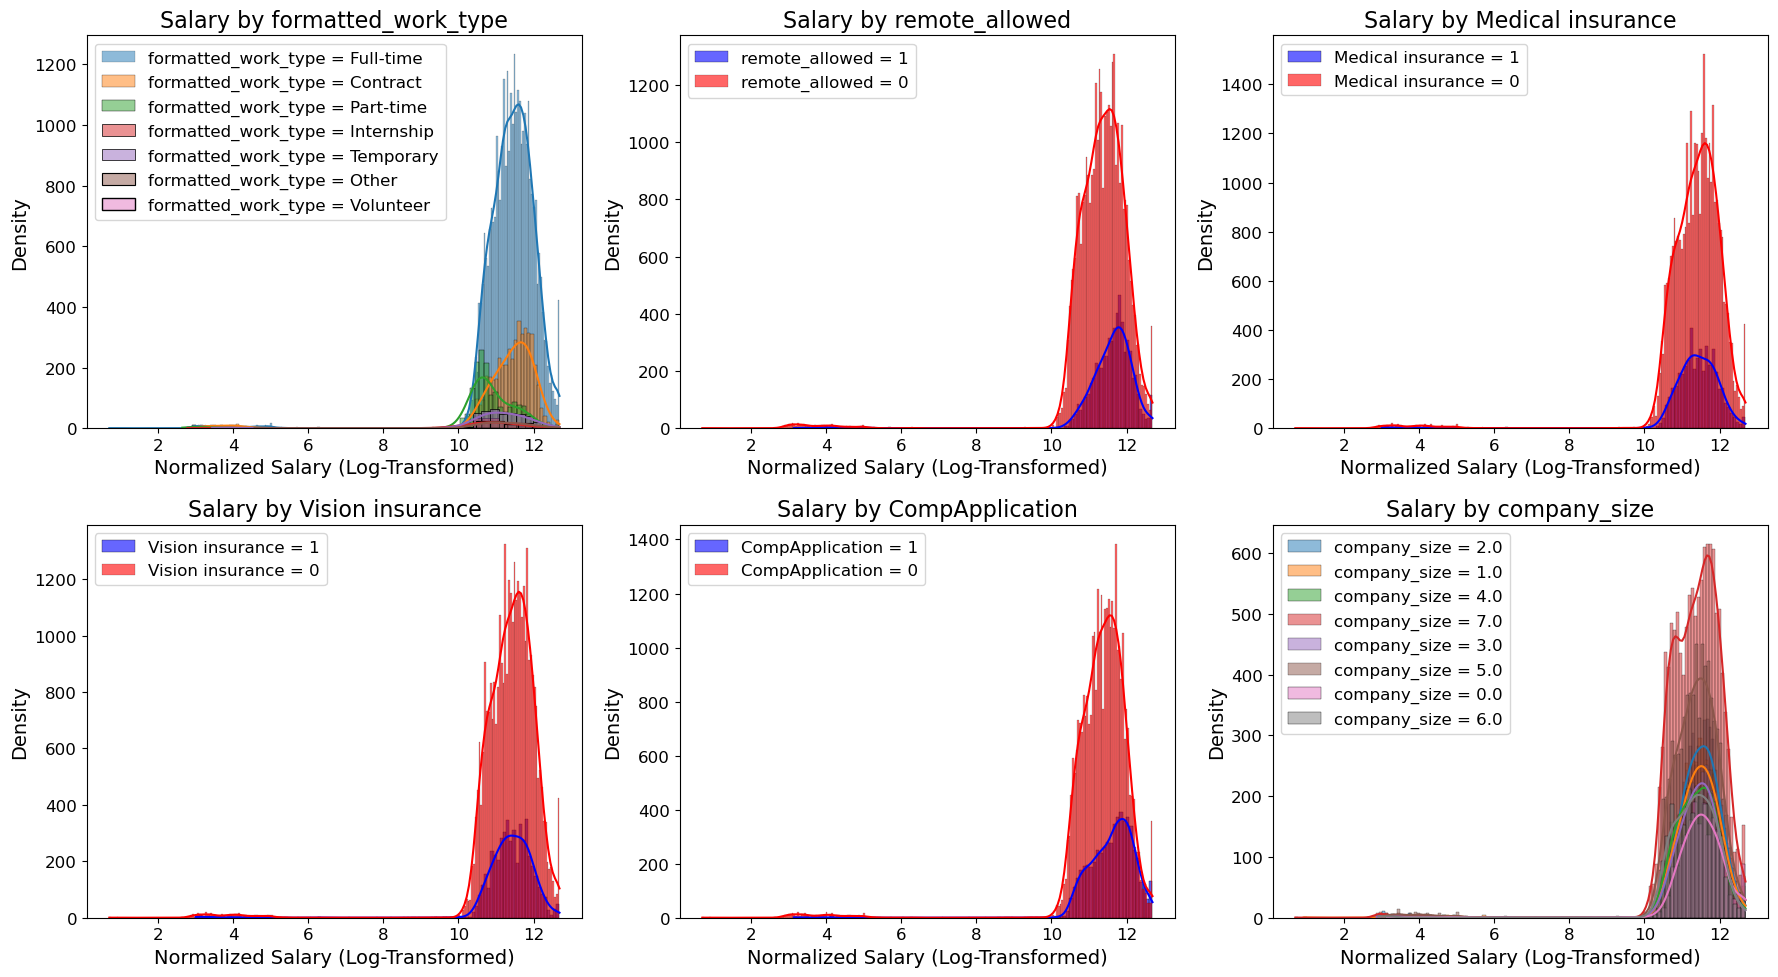

In [17]:
invalid_categoricals = ["compensation_type_x", "Child care support", "Commuter benefits", "Dental insurance", "Disability insurance", "Paid maternity leave",
  "Paid paternity leave", "Pension plan", "Student loan assistance", "Tuition assistance"]
valid_categoricals = ["formatted_work_type", "remote_allowed", "Medical insurance", "Vision insurance", "CompApplication", "company_size"]
df_transformed.drop(columns = invalid_categoricals, inplace = True)

num_vars = len(valid_categoricals)
cols = 3
rows = (num_vars // cols) + (num_vars % cols > 0)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(valid_categoricals):
    ax = axes[i]

    # for multi-levels
    if col in ["formatted_work_type", "company_size"]:
        unique_levels = df_transformed[col].dropna().unique()
        
        for level in unique_levels:
            sns.histplot(df_transformed[df_transformed[col] == level]["normalized_salary"], 
                         kde=True, label=f"{col} = {level}", alpha=0.5, ax=ax)
    # for binary vars
    else:
        sns.histplot(df_transformed[df_transformed[col] == 1]["normalized_salary"], kde=True, label=f"{col} = 1", color="blue", alpha=0.6, ax=ax)
        sns.histplot(df_transformed[df_transformed[col] == 0]["normalized_salary"], kde=True, label=f"{col} = 0", color="red", alpha=0.6, ax=ax)

    ax.legend()
    ax.set_title(f"Salary by {col}")
    ax.set_xlabel("Normalized Salary (Log-Transformed)")
    ax.set_ylabel("Density")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()

In [18]:
for col in df_transformed.columns:
    if df_transformed[col].dtype == 'object' or df_transformed[col].nunique() == 2 or col == "company_size":
        print(f"\nColumn: {col}")
        top_values = df_transformed[col].value_counts(normalize=True).head(10)
        print(top_values)


Column: company_name
company_name
Insight Global                       0.010261
The Job Network                      0.006857
Robert Half                          0.005631
Jobot                                0.005581
Wells Fargo                          0.004580
Vaco                                 0.004455
LHH                                  0.004405
Citi                                 0.003979
Sherwin-Williams                     0.003804
Creative Financial Staffing (CFS)    0.003804
Name: proportion, dtype: float64

Column: location
location
United States                      0.077832
New York, NY                       0.048326
New York City Metropolitan Area    0.017894
Los Angeles, CA                    0.014515
Chicago, IL                        0.013689
Seattle, WA                        0.012313
San Francisco, CA                  0.012288
Denver, CO                         0.011712
San Diego, CA                      0.010811
Atlanta, GA                        0.010161
Name:

determine which multi-level categorical variables are useful as confounders and should be kept, and how to handle high-cardinality ones.

- company_name: Too fragmented, better to use industry or company_size.
- city, zip_code_y: Too specific and state-level is enough
- company_size & industry & TitleClean: usually affects salary
- formatted_work_type, formatted_experience_level: directly affect salary

Handling with multi-levels columns
first filtering out country = US (because US > 90%)
- state: Merge state names & use Region Encoding
- industry: Mapping LinkedIn sub-industries to the provided parent categories
  https://authoredup.com/blog/linkedin-industry-list
- TitleClean: finding their title family
- company_size: leave it as is.
- formatted_experience_level: "Director + Executive" can be merged into "Senior Leadership" for stability. "Internship" is too rare to impact causal analysis, group it into "Entry level"
- formatted_work_type: Only focus on full-time job, since it usually follow standard salary scales.
- application_type: "UnknownApply" is almost non-existent, drop it.

columns to drop: country, company_name, city, zip_code_y

In [19]:
multi_lvl_cols = ["industry", "state", "TitleClean", "company_size", "formatted_work_type", "formatted_experience_level"]

# check the structure of multi-levels columns
for col in multi_lvl_cols:
    print(col)
    print(len(df_transformed[col].unique()))
    print(df_transformed[col].unique(), "\n")

industry
137
['Mining' 'Staffing and Recruiting' 'Industrial Machinery Manufacturing'
 'Restaurants' 'Business Consulting and Services' 'Software Development'
 'Non-profit Organizations' 'Construction' 'Facilities Services'
 'IT Services and IT Consulting'
 'Renewable Energy Semiconductor Manufacturing'
 'Online Audio and Video Media' 'Airlines and Aviation'
 'Truck Transportation' 'Financial Services' 'Banking'
 'Architecture and Planning' 'Automation Machinery Manufacturing'
 'Environmental Services' 'Hospitals and Health Care' 'Retail'
 'Wellness and Fitness Services' 'Retail Apparel and Fashion'
 'Beverage Manufacturing' 'Individual and Family Services'
 'Food and Beverage Services' 'Real Estate' 'Advertising Services'
 'Education Administration Programs' 'Human Resources Services'
 'Hospitality' 'Civil Engineering' 'Professional Training and Coaching'
 'Utilities' 'Wholesale Building Materials' 'Law Practice'
 'Law Enforcement' 'Government Administration' 'Plastics Manufacturing'


In [20]:
industry_mapping = {
    # Education
    "Education Administration Programs": "Education",
    "E-Learning Providers": "Education",
    "Higher Education": "Education",
    "Primary and Secondary Education": "Education",
    "Research Services": "Education",

    # Construction
    "Wholesale Building Materials": "Construction",
    "Civil Engineering": "Construction",
    "Construction": "Construction",

    # Design
    "Architecture and Planning": "Design",
    "Design Services": "Design",
    "Graphic Design": "Design",

    # Corporate Services
    "Accounting": "Corporate Services",
    "Business Consulting and Services": "Corporate Services",
    "Environmental Services": "Corporate Services",
    "Events Services": "Corporate Services",
    "Executive Offices": "Corporate Services",
    "Facilities Services": "Corporate Services",
    "Human Resources Services": "Corporate Services",
    "Information Services": "Corporate Services",
    "Management Consulting": "Corporate Services",
    "Outsourcing and Offshoring Consulting": "Corporate Services",
    "Professional Training and Coaching": "Corporate Services",
    "Security and Investigations": "Corporate Services",
    "Staffing and Recruiting": "Corporate Services",
    "Retail Office Equipment": "Corporate Services",

    # Retail
    "Retail": "Retail",
    "Retail Groceries": "Retail",
    "Wholesale": "Retail",
    "Retail Apparel and Fashion": "Retail",

    # Energy and Mining
    "Mining": "Energy and Mining",
    "Oil and Gas": "Energy and Mining",
    "Utilities": "Energy and Mining",

    # Manufacturing
    "Automation Machinery Manufacturing": "Manufacturing",
    "Aviation and Aerospace Component Manufacturing": "Manufacturing",
    "Chemical Manufacturing": "Manufacturing",
    "Defense and Space Manufacturing": "Manufacturing",
    "Appliances, Electrical, and Electronics Manufacturing": "Manufacturing",
    "Food and Beverage Manufacturing": "Manufacturing",
    "Glass, Ceramics and Concrete Manufacturing": "Manufacturing",
    "Machinery Manufacturing": "Manufacturing",
    "Mechanical or Industrial Engineering": "Manufacturing",
    "Packaging and Containers Manufacturing": "Manufacturing",
    "Paper and Forest Product Manufacturing": "Manufacturing",
    "Plastics Manufacturing": "Manufacturing",
    "Railroad Equipment Manufacturing": "Manufacturing",
    "Renewable Energy Semiconductor Manufacturing": "Manufacturing",
    "Shipbuilding": "Manufacturing",
    "Textile Manufacturing": "Manufacturing",
    "Industrial Machinery Manufacturing": "Manufacturing",
    "Manufacturing": "Manufacturing",
    "Motor Vehicle Manufacturing": "Manufacturing",

    # Finance
    "Banking": "Finance",
    "Capital Markets": "Finance",
    "Financial Services": "Finance",
    "Insurance": "Finance",
    "Investment Banking": "Finance",
    "Investment Management": "Finance",
    "Venture Capital and Private Equity Principals": "Finance",

    # Recreation and Travel
    "Airlines and Aviation": "Recreation and Travel",
    "Gambling Facilities and Casinos": "Recreation and Travel",
    "Hospitality": "Recreation and Travel",
    "Leisure, Travel and Tourism": "Recreation and Travel",
    "Restaurants": "Recreation and Travel",
    "Recreational Facilities": "Recreation and Travel",
    "Spectator Sports": "Recreation and Travel",
    "Travel Arrangements": "Recreation and Travel",

    # Arts
    "Arts and Crafts": "Arts",
    "Fine Art": "Arts",
    "Performing Arts": "Arts",
    "Photography": "Arts",
    "Artists and Writers": "Arts",

    # Healthcare
    "Biotechnology Research": "Healthcare",
    "Hospitals and Health Care": "Healthcare",
    "Medical Equipment Manufacturing": "Healthcare",
    "Medical Practices": "Healthcare",
    "Mental Health Care": "Healthcare",
    "Pharmaceutical Manufacturing": "Healthcare",
    "Veterinary Services": "Healthcare",

    # Hardware and Networking
    "Computer Hardware Manufacturing": "Hardware and Networking",
    "Computer Networking Products": "Hardware and Networking",
    "Nanotechnology Research": "Hardware and Networking",
    "Semiconductor Manufacturing": "Hardware and Networking",
    "Telecommunications": "Hardware and Networking",
    "Wireless Services": "Hardware and Networking",
    "Computers and Electronics Manufacturing": "Hardware and Networking",

    # Real Estate
    "Commercial Real Estate": "Real Estate",
    "Real Estate": "Real Estate",
    "Leasing Non-residential Real Estate": "Real Estate",

    # Legal
    "Alternative Dispute Resolution": "Legal",
    "Law Practice": "Legal",
    "Legal Services": "Legal",

    # Consumer Goods
    "Retail Apparel and Fashion": "Consumer Goods",
    "Consumer Electronics": "Consumer Goods",
    "Consumer Goods": "Consumer Goods",
    "Consumer Services": "Consumer Goods",
    "Cosmetics": "Consumer Goods",
    "Beverage Manufacturing": "Consumer Goods",
    "Furniture and Home Furnishings Manufacturing": "Consumer Goods",
    "Retail Luxury Goods and Jewelry": "Consumer Goods",
    "Sporting Goods Manufacturing": "Consumer Goods",
    "Tobacco Manufacturing": "Consumer Goods",
    "Wine and Spirits": "Consumer Goods",
    "Book and Periodical Publishing": "Consumer Goods",
    "Food and Beverage Services": "Consumer Goods",
    "Personal Care Product Manufacturing": "Consumer Goods",

    # Agriculture
    "Dairy Product Manufacturing": "Agriculture",
    "Farming": "Agriculture",
    "Fisheries": "Agriculture",
    "Ranching": "Agriculture",

    # Media and Communications
    "Market Research": "Media and Communications",
    "Marketing & Advertising": "Media and Communications",
    "Newspaper Publishing": "Media and Communications",
    "Online Audio and Video Media": "Media and Communications",
    "Printing Services": "Media and Communications",
    "Public Relations and Communications Services": "Media and Communications",
    "Publishing": "Media and Communications",
    "Translation and Localization": "Media and Communications",
    "Writing and Editing": "Media and Communications",
    "Advertising Services": "Media and Communications",

    # Nonprofit
    "Civic and Social Organizations": "Nonprofit",
    "Fundraising": "Nonprofit",
    "Individual and Family Services": "Nonprofit",
    "International Trade and Development": "Nonprofit",
    "Libraries": "Nonprofit",
    "Museums, Historical Sites, and Zoos": "Nonprofit",
    "Non-profit Organizations": "Nonprofit",
    "Philanthropic Fundraising Services": "Nonprofit",
    "Program Development": "Nonprofit",
    "Religious Institutions": "Nonprofit",
    "Think Tanks": "Nonprofit",

    # Software and IT Services
    "Computer and Network Security": "Software and IT Services",
    "Software Development": "Software and IT Services",
    "Technology, Information and Internet": "Software and IT Services",
    "Internet": "Software and IT Services",
    "IT Services and IT Consulting": "Software and IT Services",

    # Transportation and Logistics
    "Import and Export": "Transportation and Logistics",
    "Logistics and Supply Chain": "Transportation and Logistics",
    "Maritime Transportation": "Transportation and Logistics",
    "Freight and Package Transportation": "Transportation and Logistics",
    "Transportation, Logistics, Supply Chain and Storage": "Transportation and Logistics",
    "Warehousing and Storage": "Transportation and Logistics",
    "Truck Transportation": "Transportation and Logistics",

    # Entertainment
    "Animation": "Entertainment",
    "Broadcast Media Production and Distribution": "Entertainment",
    "Computer Games": "Entertainment",
    "Entertainment Providers": "Entertainment",
    "Media Production": "Entertainment",
    "Mobile Games": "Entertainment",
    "Motion Pictures and Film": "Entertainment",
    "Musicians": "Entertainment",

    # Wellness and Fitness
    "Alternative Medicine": "Wellness and Fitness",
    "Wellness and Fitness Services": "Wellness and Fitness",

    # Public Safety
    "Law Enforcement": "Public Safety",
    "Armed Forces": "Public Safety",
    "Public Safety": "Public Safety",
    "Government Relations Services": "Public Safety",

    # Public Administration
    "Government Administration": "Public Administration",
    "Government Relations": "Public Administration",
    "International Affairs": "Public Administration",
    "Judiciary": "Public Administration",
    "Legislative Offices": "Public Administration",
    "Political Organizations": "Public Administration",
    "Public Policy Offices": "Public Administration",
    "Administration of Justice": "Public Administration",
}

#### verify mapping###
mapped_industries = set(industry_mapping.keys())
existing_industries = set(df_transformed["industry"].unique())
unmapped_industries = existing_industries - mapped_industries
print("Industries not mapped:\n")
for i in unmapped_industries:
    print(i)

df_transformed["industry"] = df_transformed["industry"].map(industry_mapping)
print(len(df_transformed["industry"].unique()))

Industries not mapped:

24


In [ ]:
# filter out country in US
print(df_transformed.shape)
df_transformed = df_transformed[df_transformed["country"] == "US"]
df_transformed.drop(columns = ["location", "country", "company_name", "city", "zip_code_y"], inplace=True)
print(df_transformed.shape)

state_mapping = {
    "AL": "Alabama", "Alabama": "Alabama",
    "AK": "Alaska", "Alaska": "Alaska",
    "AZ": "Arizona", "Arizona": "Arizona", "Arizona ": "Arizona",
    "AR": "Arkansas", "Arkansas": "Arkansas",
    "CA": "California", "California": "California", "california": "California",
    "CA ": "California", "CA - California": "California", "CA California": "California", "Californië": "California",
    "CO": "Colorado", "Colorado": "Colorado", "co": "Colorado", "Colorado ": "Colorado", "Colorado/Utah": "Colorado",
    "CT": "Connecticut", "Connecticut": "Connecticut",
    "DE": "Delaware", "Delaware": "Delaware",
    "FL": "Florida", "Florida": "Florida", "fl": "Florida", "Fl": "Florida", "FL ": "Florida",
    "GA": "Georgia", "Georgia": "Georgia", "ga": "Georgia", "Ga": "Georgia", "Ga.": "Georgia", "Georgia ": "Georgia",
    "HI": "Hawaii", "Hawaii": "Hawaii", "Hi": "Hawaii",
    "ID": "Idaho", "Idaho": "Idaho", "Id": "Idaho",
    "IL": "Illinois", "Illinois": "Illinois", "il": "Illinois", "Il": "Illinois", "IL ": "Illinois", "Illinois ": "Illinois",
    "IN": "Indiana", "Indiana": "Indiana",
    "IA": "Iowa", "Iowa": "Iowa",
    "KS": "Kansas", "Kansas": "Kansas",
    "KY": "Kentucky", "Kentucky": "Kentucky", "ky": "Kentucky", "Ky": "Kentucky",
    "LA": "Louisiana", "Louisiana": "Louisiana", "Louisiana ": "Louisiana", "LA - Louisiana": "Louisiana", "La": "Louisiana", "Louisianna": "Louisiana",
    "ME": "Maine", "Maine": "Maine",
    "MD": "Maryland", "Maryland": "Maryland", "md": "Maryland", "Maryland ": "Maryland",
    "MA": "Massachusetts", "Massachusetts": "Massachusetts", "ma": "Massachusetts", "MASSACHUSETTS": "Massachusetts", "Massachusetts ": "Massachusetts",
    "MI": "Michigan", "Michigan": "Michigan",
    "MN": "Minnesota", "Minnesota": "Minnesota", "MN ": "Minnesota", "Minnesota ": "Minnesota",
    "MS": "Mississippi", "Mississippi": "Mississippi",
    "MO": "Missouri", "Missouri": "Missouri", "mo": "Missouri", "MO - Missouri": "Missouri", "Missouri ": "Missouri",
    "MT": "Montana", "Montana": "Montana",
    "NE": "Nebraska", "Nebraska": "Nebraska",
    "NV": "Nevada", "Nevada": "Nevada",
    "NH": "New Hampshire", "New Hampshire": "New Hampshire",
    "NJ": "New Jersey", "New Jersey": "New Jersey", "new jersey": "New Jersey",
    "NM": "New Mexico", "New Mexico": "New Mexico",
    "NY": "New York", "New York": "New York", "new york": "New York", "NY ": "New York", "ny": "New York", 
    "New York (NY)": "New York", "New york": "New York", "NY - New York": "New York",
    "NC": "North Carolina", "North Carolina": "North Carolina", "NORTH CAROLINA": "North Carolina",
    "ND": "North Dakota", "North Dakota": "North Dakota",
    "OH": "Ohio", "Ohio": "Ohio", "oh": "Ohio",
    "OK": "Oklahoma", "Oklahoma": "Oklahoma",
    "OR": "Oregon", "Oregon": "Oregon", "Or": "Oregon", "OR - Oregon": "Oregon",
    "PA": "Pennsylvania", "Pennsylvania": "Pennsylvania", "Pa": "Pennsylvania", "PA ": "Pennsylvania",
    "RI": "Rhode Island", "Rhode Island": "Rhode Island",
    "SC": "South Carolina", "South Carolina": "South Carolina",
    "SD": "South Dakota", "South Dakota": "South Dakota",
    "TN": "Tennessee", "Tennessee": "Tennessee", "Tn": "Tennessee",
    "TX": "Texas", "Texas": "Texas", "tx": "Texas", "Tx": "Texas", "Texas ": "Texas",
    "UT": "Utah", "Utah": "Utah",
    "VT": "Vermont", "Vermont": "Vermont",
    "VA": "Virginia", "Virginia": "Virginia", "va": "Virginia", "Va": "Virginia",
    "WA": "Washington", "Washington": "Washington", "wa": "Washington", "WA ": "Washington", "Washington ": "Washington",
    "WV": "West Virginia", "West Virginia": "West Virginia",
    "WI": "Wisconsin", "Wisconsin": "Wisconsin", "wi": "Wisconsin", "Wisconsin ": "Wisconsin",
    "WY": "Wyoming", "Wyoming": "Wyoming",

    # Variations / Misspellings / Mixed Case Fixes
    "CALIFORNIA": "California", "ca": "California", "Ca": "California", "Ca.": "California",
    "FLORIDA": "Florida", "fl": "Florida", "Fl": "Florida", "florida": "Florida", "Florida ": "Florida",
    "NY - New York": "New York", "NEW YORK": "New York", "New York ": "New York", "New York, NY": "New York",
    "ny": "New York", "Ny": "New York", "NY ": "New York", "new york": "New York",
    "NJ": "New Jersey", "NEW JERSEY": "New Jersey", "New Jersey ": "New Jersey", "new jersey": "New Jersey",
    "TX": "Texas", "TEXAS": "Texas", "Tx": "Texas", "tx": "Texas", "Texas ": "Texas",
    "WA": "Washington", "wa": "Washington", "Wa": "Washington", "WA ": "Washington", "WASHINGTON": "Washington",
    "DC": "District of Columbia", "D.C.": "District of Columbia", "DISTRICT OF COLUMBIA": "District of Columbia",
    "Virginia ": "Virginia", "Virgina": "Virginia",
    "MO - Missouri": "Missouri", "Missouri ": "Missouri",
    "MASSACHUSETTS": "Massachusetts", "ma": "Massachusetts",
    "Wisconsin ": "Wisconsin", "WISCONSIN": "Wisconsin",
    "OKLAHOMA": "Oklahoma", "OK": "Oklahoma",
    "CONNECTICUT": "Connecticut",
    "Pennsylvania ": "Pennsylvania", "pa": "Pennsylvania",
    "Plymouth Meeting, PA,": "Pennsylvania",
    
    # Cities / Non-state locations that need reclassification
    "Washington DC": "District of Columbia",
    "District of Columbia": "District of Columbia",
    "Greater London": "Other",
    "New York [NY]": "New York",
    "Plymouth Meeting, PA, ": "Pennsylvania",
    "Bassett, VA": "Virginia",
    "DALLAS": "Texas",
    "Brooklyn": "New York",
    
    # Garbage / Ambiguous / Invalid Data
    "0": "Other", "Global": "Other", "globally": "Other", "1824": "Other", "94086": "Other",
    "US state": "Other", "USA": "Other", "US": "Other", "N.W.": "Other",
    "2141 s 211th St #G": "Other", "55077": "Other", "99669": "Other",
    
    # Edge cases (state-country combos)
    "IN/FL/IL": "Other",  # Multiple states, ambiguous
    "CO - Colorado": "Colorado",
    "FL - Florida": "Florida",
    "NY - New York": "New York",
    "IL - Illinois": "Illinois",
    "AZ - Arizona": "Arizona",
    "UT Utah": "Utah",
}

#### verify mapping###
df_transformed["state"] = df_transformed["state"].str.strip()
mapped_state = set(state_mapping.keys())
existing_state = set(df_transformed["state"].unique())
unmapped_state = existing_state - mapped_state
print("state not mapped:\n")
unmapped_state

df_transformed["state"] = df_transformed["state"].map(state_mapping)
len(df_transformed["state"].unique())

(39958, 27)
(35991, 22)
state not mapped:



52

In [ ]:
title_df = pd.DataFrame(df_transformed["TitleClean"].value_counts()).reset_index()
title_df.columns = ["title", "count"]
title_df["proportion"] = title_df["count"] / title_df["count"].sum()
title_df

title  count  proportion
0               project manager   9327    0.259148
1             software engineer   2052    0.057014
2             senior accountant   1635    0.045428
3            support specialist   1475    0.040982
4              business analyst   1086    0.030174
5      administrative assistant   1027    0.028535
6        maintenance technician    955    0.026534
7               sales associate    909    0.025256
8          sales representative    883    0.024534
9          business development    674    0.018727
10             registered nurse    667    0.018532
11             customer service    589    0.016365
12            account executive    584    0.016226
13              program manager    496    0.013781
14          project coordinator    480    0.013337
15              senior director    473    0.013142
16           operations manager    441    0.012253
17              product manager    440    0.012225
18            marketing manager    408    0.011336
19            financial analyst    384    0.010669
20              human resources    360    0.010003
21              account manager    350    0.009725
22                 data analyst    337    0.009363
23           accounting manager    326    0.009058
24                  home health    320    0.008891
25               senior manager    307    0.008530
26           associate attorney    306    0.008502
27                    travel rn    296    0.008224
28             staff accountant    281    0.007808
29            medical assistant    277    0.007696
30             sales consultant    266    0.007391
31           physical therapist    256    0.007113
32          executive assistant    253    0.007030
33                sales manager    247    0.006863
34              design engineer    216    0.006002
35          electrical engineer    210    0.005835
36               vice president    208    0.005779
37               data scientist    203    0.005640
38             quality engineer    198    0.005501
39       information technology    197    0.005474
40              general manager    197    0.005474
41            security engineer    195    0.005418
42          engineering manager    189    0.005251
43             systems engineer    183    0.005085
44          warehouse associate    179    0.004973
45            technical support    164    0.004557
46                store manager    164    0.004557
47            assistant manager    155    0.004307
48                    2nd shift    151    0.004195
49       manufacturing engineer    145    0.004029
50                  entry level    143    0.003973
51                data engineer    137    0.003807
52                  engineer ii    134    0.003723
53                  tax manager    133    0.003695
54               office manager    130    0.003612
55                  real estate    128    0.003556
56             accounts payable    127    0.003529
57              legal assistant    125    0.003473
58            quality assurance    123    0.003418
59             project engineer    121    0.003362
60           associate director    110    0.003056
61                mental health    107    0.002973
62           service technician    107    0.002973
63             process engineer    106    0.002945
64         litigation associate    105    0.002917
65            financial advisor    105    0.002917
66                 supply chain    103    0.002862
67                field service    101    0.002806
68              finance manager     99    0.002751
69             network engineer     99    0.002751
70          mechanical engineer     98    0.002723
71         construction project     98    0.002723
72              sales executive     93    0.002584
73             sales specialist     92    0.002556
74           nurse practitioner     92    0.002556
75         marketing specialist     85    0.002362
76           payroll specialist     84    0.002334
77   development representative     80    0.0022

In [23]:
title_mapping = {
    # Project/Product Management
    "project manager": "Project/Product Management",
    "program manager": "Project/Product Management",
    "project coordinator": "Project/Product Management",
    "senior project": "Project/Product Management",
    "construction project": "Project/Product Management",
    "construction superintendent": "Project/Product Management",
    "product manager": "Project/Product Management",
    "senior product": "Project/Product Management",

    # Software Engineering
    "software engineer": "Software Engineering",
    "senior software": "Software Engineering",
    "development engineer": "Software Engineering",
    "network engineer": "Software Engineering",
    "security engineer": "Software Engineering",
    "systems engineer": "Software Engineering",
    "engineering manager": "Software Engineering",
    "project engineer": "Software Engineering",
    "field service": "Software Engineering",

    # Data & Analytics
    "data scientist": "Data & Analytics",
    "data analyst": "Data & Analytics",
    "data engineer": "Data & Analytics",
    "business analyst": "Data & Analytics",
    "financial analyst": "Data & Analytics",
    "senior data": "Data & Analytics",

    # Sales & Business Development
    "sales representative": "Sales & Business",
    "sales associate": "Sales & Business",
    "sales consultant": "Sales & Business",
    "sales manager": "Sales & Business",
    "business development": "Sales & Business",
    "sales executive": "Sales & Business",
    "account executive": "Sales & Business",
    "inside sales": "Sales & Business",
    "outside sales": "Sales & Business",
    "sales specialist": "Sales & Business",
    "sales development": "Sales & Business",
    "account manager": "Sales & Business",
    "store manager": "Sales & Business",
    "assistant store": "Sales & Business",
    "development representative": "Sales & Business",
    "development manager": "Sales & Business",

    # Customer Support
    "support specialist": "Customer Support",
    "customer service": "Customer Support",
    "service representative": "Customer Support",
    "technical support": "Customer Support",
    "service technician": "Customer Support",
    "maintenance technician": "Customer Support",
    "field service": "Customer Support",
    "information technology": "Customer Support",

    # Accounting & Finance
    "accounting manager": "Accounting & Finance",
    "staff accountant": "Accounting & Finance",
    "senior accountant": "Accounting & Finance",
    "financial advisor": "Accounting & Finance",
    "tax manager": "Accounting & Finance",
    "senior tax": "Accounting & Finance",
    "senior financial": "Accounting & Finance",
    "finance manager": "Accounting & Finance",
    "accounts payable": "Accounting & Finance",
    "accounts receivable": "Accounting & Finance",
    "payroll specialist": "Accounting & Finance",

    # Marketing
    "marketing specialist": "Marketing",
    "marketing manager": "Marketing",

    # Engineering & Manufacturing
    "manufacturing engineer": "Engineering",
    "design engineer": "Engineering",
    "quality engineer": "Engineering",
    "test engineer": "Engineering",
    "process engineer": "Engineering",
    "mechanical engineer": "Engineering",
    "electrical engineer": "Engineering",
    "engineer ii": "Engineering",
    "quality assurance": "Engineering",

    # Operations & HR
    "human resources": "Operations & HR",
    "resources manager": "Operations & HR",
    "operations manager": "Operations & HR",
    "operations specialist": "Operations & HR",
    "resources generalist": "Operations & HR",
    "administrative assistant": "Operations & HR",
    "assistant manager": "Operations & HR",
    "office manager": "Operations & HR", 
    "executive assistant": "Operations & HR",

    # Medical & Healthcare
    "registered nurse": "Medical & Healthcare",
    "nurse practitioner": "Medical & Healthcare",
    "physical therapist": "Medical & Healthcare",
    "medical assistant": "Medical & Healthcare",
    "mental health": "Medical & Healthcare",
    "home health": "Medical & Healthcare",
    "travel rn": "Medical & Healthcare",
    "med surg": "Medical & Healthcare",
    "nurse rn": "Medical & Healthcare",

    # Legal & Real Estate
    "legal assistant": "Legal & Real Estate",
    "associate attorney": "Legal & Real Estate",
    "litigation associate": "Legal & Real Estate",
    "real estate": "Legal & Real Estate",

    # Senior Leadership & Management
    "senior manager": "Senior Leadership",
    "senior director": "Senior Leadership",
    "associate director": "Senior Leadership",
    "vice president": "Senior Leadership",
    "general manager": "Senior Leadership",

    # Logistics & Supply Chain
    "warehouse associate": "Logistics & Supply Chain",
    "supply chain": "Logistics & Supply Chain",

    # Other Roles
    "entry level": "Other",
    "2nd shift": "Other"
}

#### Verify Mapping###
mapped_title = set(title_mapping.keys())
existing_title = set(df_transformed["TitleClean"].unique())
unmapped_title = existing_title - mapped_title
print("Titles not mapped:\n")
for i in unmapped_title:
    print(i)

df_transformed["title_family"] = df_transformed["TitleClean"].map(title_mapping)
print(len(df_transformed["title_family"].unique()))

Titles not mapped:

14


In [24]:
df_transformed["formatted_experience_level"] = df_transformed["formatted_experience_level"].replace(
    {"Internship": "Entry level", 
     "Executive": "Senior Leadership",
     "Director": "Senior Leadership"}
)
df_transformed["formatted_experience_level"].value_counts()

formatted_experience_level
Mid-Senior level     13791
Other                 7853
Entry level           7567
Associate             4809
Senior Leadership     1971
Name: count, dtype: int64

In [25]:
# focus only Full-time
print(df_transformed.shape)
df_transformed = df_transformed[df_transformed["formatted_work_type"] == "Full-time"]
df_transformed.drop(columns = ["formatted_work_type"], inplace=True)
print(df_transformed.shape)

(35991, 23)
(29439, 22)


In [26]:
# exclude UnknownApply
print(df_transformed.shape)
df_transformed = df_transformed[df_transformed["application_type"] != "UnknownApply"]
df_transformed.drop(columns = ["application_type"], inplace=True)
print(df_transformed.shape)

(29439, 22)
(29438, 21)


In [27]:
for col in df_transformed.drop(columns=["TitleClean"]).columns:
    if df_transformed[col].dtype == 'object' or df_transformed[col].nunique() == 2 or col == "company_size" and col != "TitleClean":
        print(f"\nColumn: {col}")
        top_values = df_transformed[col].value_counts(normalize=True)
        print(top_values)


Column: remote_allowed
remote_allowed
0.0    0.864291
1.0    0.135709
Name: proportion, dtype: float64

Column: formatted_experience_level
formatted_experience_level
Mid-Senior level     0.373191
Other                0.236803
Entry level          0.205347
Associate            0.121510
Senior Leadership    0.063150
Name: proportion, dtype: float64

Column: company_size
company_size
7.0    0.320300
5.0    0.178918
2.0    0.120762
1.0    0.101026
3.0    0.077451
4.0    0.073409
6.0    0.072084
0.0    0.056050
Name: proportion, dtype: float64

Column: state
state
California              0.218731
New York                0.134622
Texas                   0.060942
Illinois                0.048882
Florida                 0.039235
Washington              0.036382
Georgia                 0.034785
Virginia                0.034615
Massachusetts           0.034343
Other                   0.029588
Ohio                    0.028908
New Jersey              0.026938
Colorado                0.025341
Penn

In [28]:
df_transformed[numeric_columns].describe()

views       applies  follower_count  employee_count  \
count  29438.000000  29438.000000    29438.000000    29438.000000   
mean       2.030416      0.425524       10.902830        7.091730   
std        1.036856      0.884832        2.532225        2.857587   
min        0.000000      0.000000        0.000000        0.000000   
25%        1.386294      0.000000        9.320897        4.828314   
50%        1.791759      0.000000       10.915043        7.326794   
75%        2.397895      0.693147       12.511143        9.394933   
max        9.207937      6.593045       17.301678       13.525199   

       max_hourly_salary_in_usd  min_hourly_salary_in_usd  \
count              29438.000000              29438.000000   
mean                   3.934912                  3.627046   
std                    0.672841                  0.635369   
min                    0.000481                  0.000481   
25%                    3.545409                  3.288122   
50%                    3.947705                  3.656883   
75%                    4.330534                  3.987625   
max                   12.524530                 12.388398   

       job_posting_duration  normalized_salary  max_salary_in_usd  \
count          29438.000000       29438.000000       29438.000000   
mean               3.507927          11.377293           9.734110   
std                0.365296           0.854091           3.525724   
min                2.197225           0.693147           0.693147   
25%                3.433987          11.042938          10.389026   
50%                3.433987          11.434975          11.512935   
75%                3.433987          11.813037          11.918397   
max                5.198497          12.691584          12.861001   

       min_salary_in_usd  
count       29438.000000  
mean            9.418040  
std             3.495086  
min             0.693147  
25%             9.163354  
50%            11.188247  
75%            11.608245  
max            12.429220

- Correlation Between Categorical Variables

- Salary distribution among Levels of Categorical Variables

- Correlation Between Categorical & Numerical Variables

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/3106164514.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_transformed[df_transformed[col] == 1]["normalized_salary"],
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/3106164514.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_transformed[df_transformed[col] == 0]["normalized_salary"],
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/3106164514.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_transformed[df_transformed[col] == 1]["normalized_salary"],
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipy

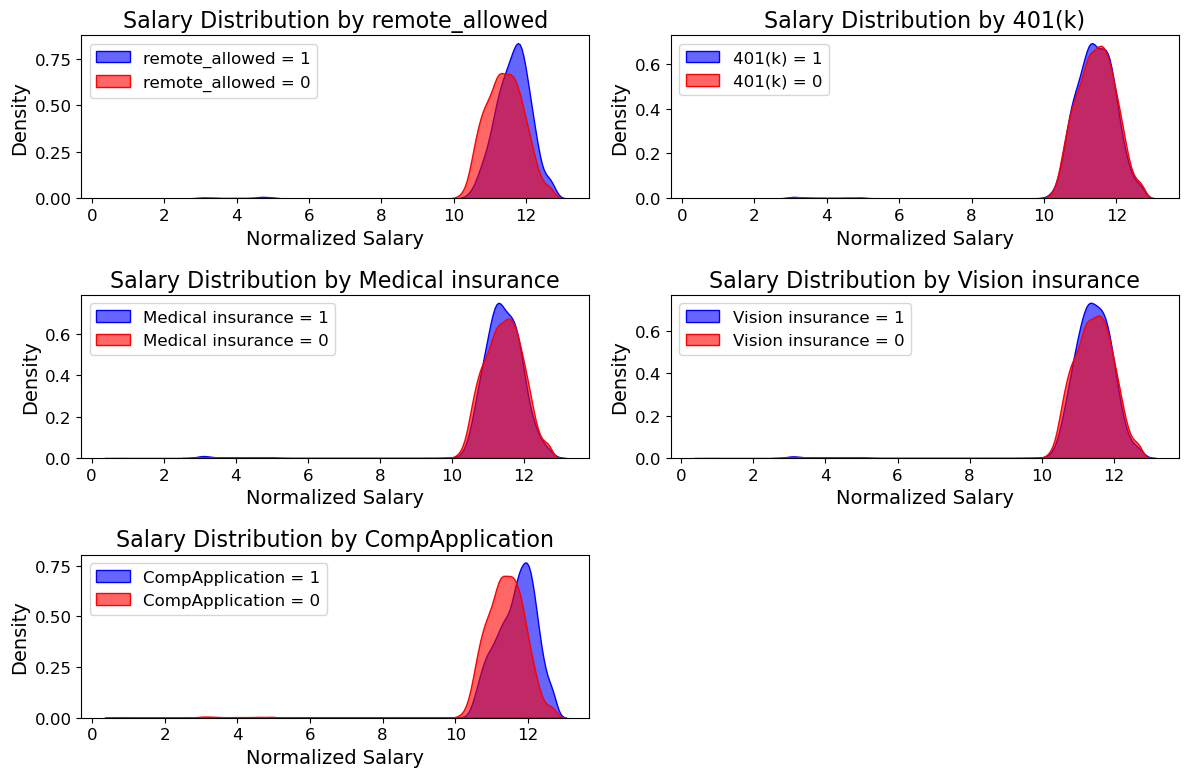

In [30]:
# binary variables
bin_cols = ["remote_allowed", "401(k)", "Medical insurance", "Vision insurance", "CompApplication"]

num_cols = 2
num_rows = -(-len(bin_cols) // num_cols) 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

axes = axes.flatten()

for i, col in enumerate(bin_cols):
    ax = axes[i]
    
    sns.kdeplot(df_transformed[df_transformed[col] == 1]["normalized_salary"], 
                label=f"{col} = 1", shade=True, color="blue", alpha=0.6, ax=ax)
    
    sns.kdeplot(df_transformed[df_transformed[col] == 0]["normalized_salary"], 
                label=f"{col} = 0", shade=True, color="red", alpha=0.6, ax=ax)

    ax.legend()
    ax.set_title(f"Salary Distribution by {col}")
    ax.set_xlabel("Normalized Salary")
    ax.set_ylabel("Density")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/621415608.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=9)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/621415608.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=9)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/621415608.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=9)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/621415608.py:21: UserWarning: set_ticklabels() should only be use

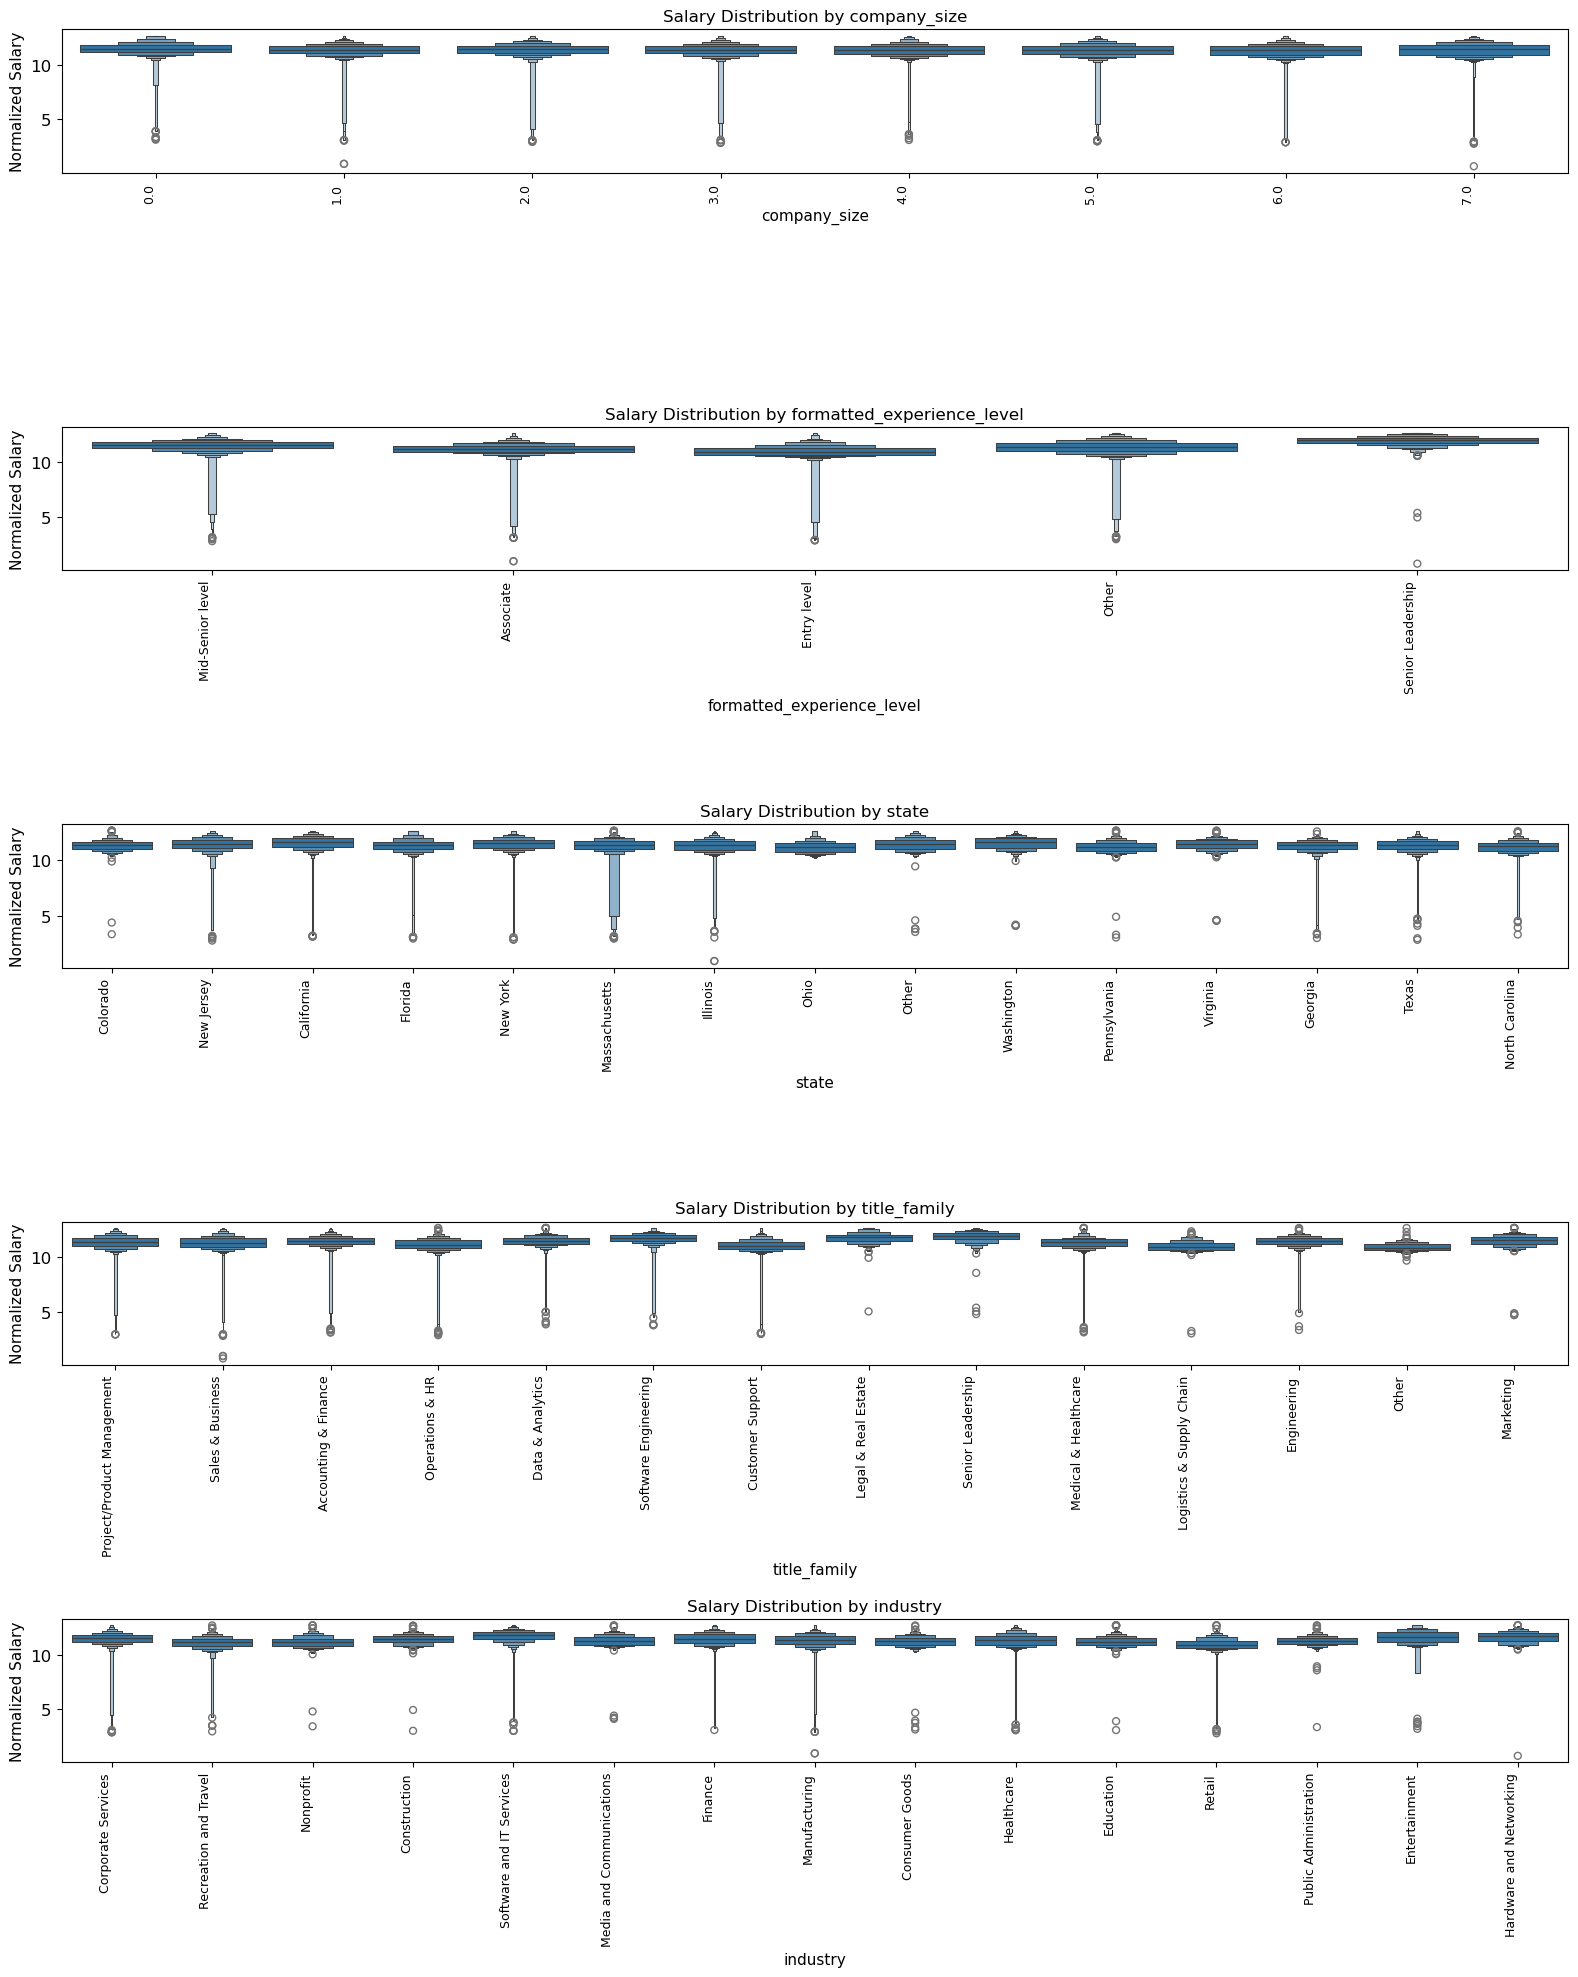

In [31]:
# company_size, formatted_experience_level, state, title_family, industry
multi_lvl_cols = ["company_size", "formatted_experience_level", "state", "title_family", "industry"]

num_cols = 1
num_rows = len(multi_lvl_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 20))  # Increase height for readability

for i, col in enumerate(multi_lvl_cols):
    ax = axes[i]

    # top 15
    top_categories = df_transformed[col].value_counts().index[:15]

    sns.boxenplot(data=df_transformed[df_transformed[col].isin(top_categories)], 
                  x=col, y="normalized_salary", ax=ax)

    ax.set_title(f"Salary Distribution by {col}", fontsize=12)
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel("Normalized Salary", fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=9)

plt.tight_layout()
plt.show()

/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/161089397.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/161089397.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/161089397.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
/var/folders/zk/tdbf0qq57717wv6g_psgrjk40000gn/T/ipykernel_19915/161089397.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

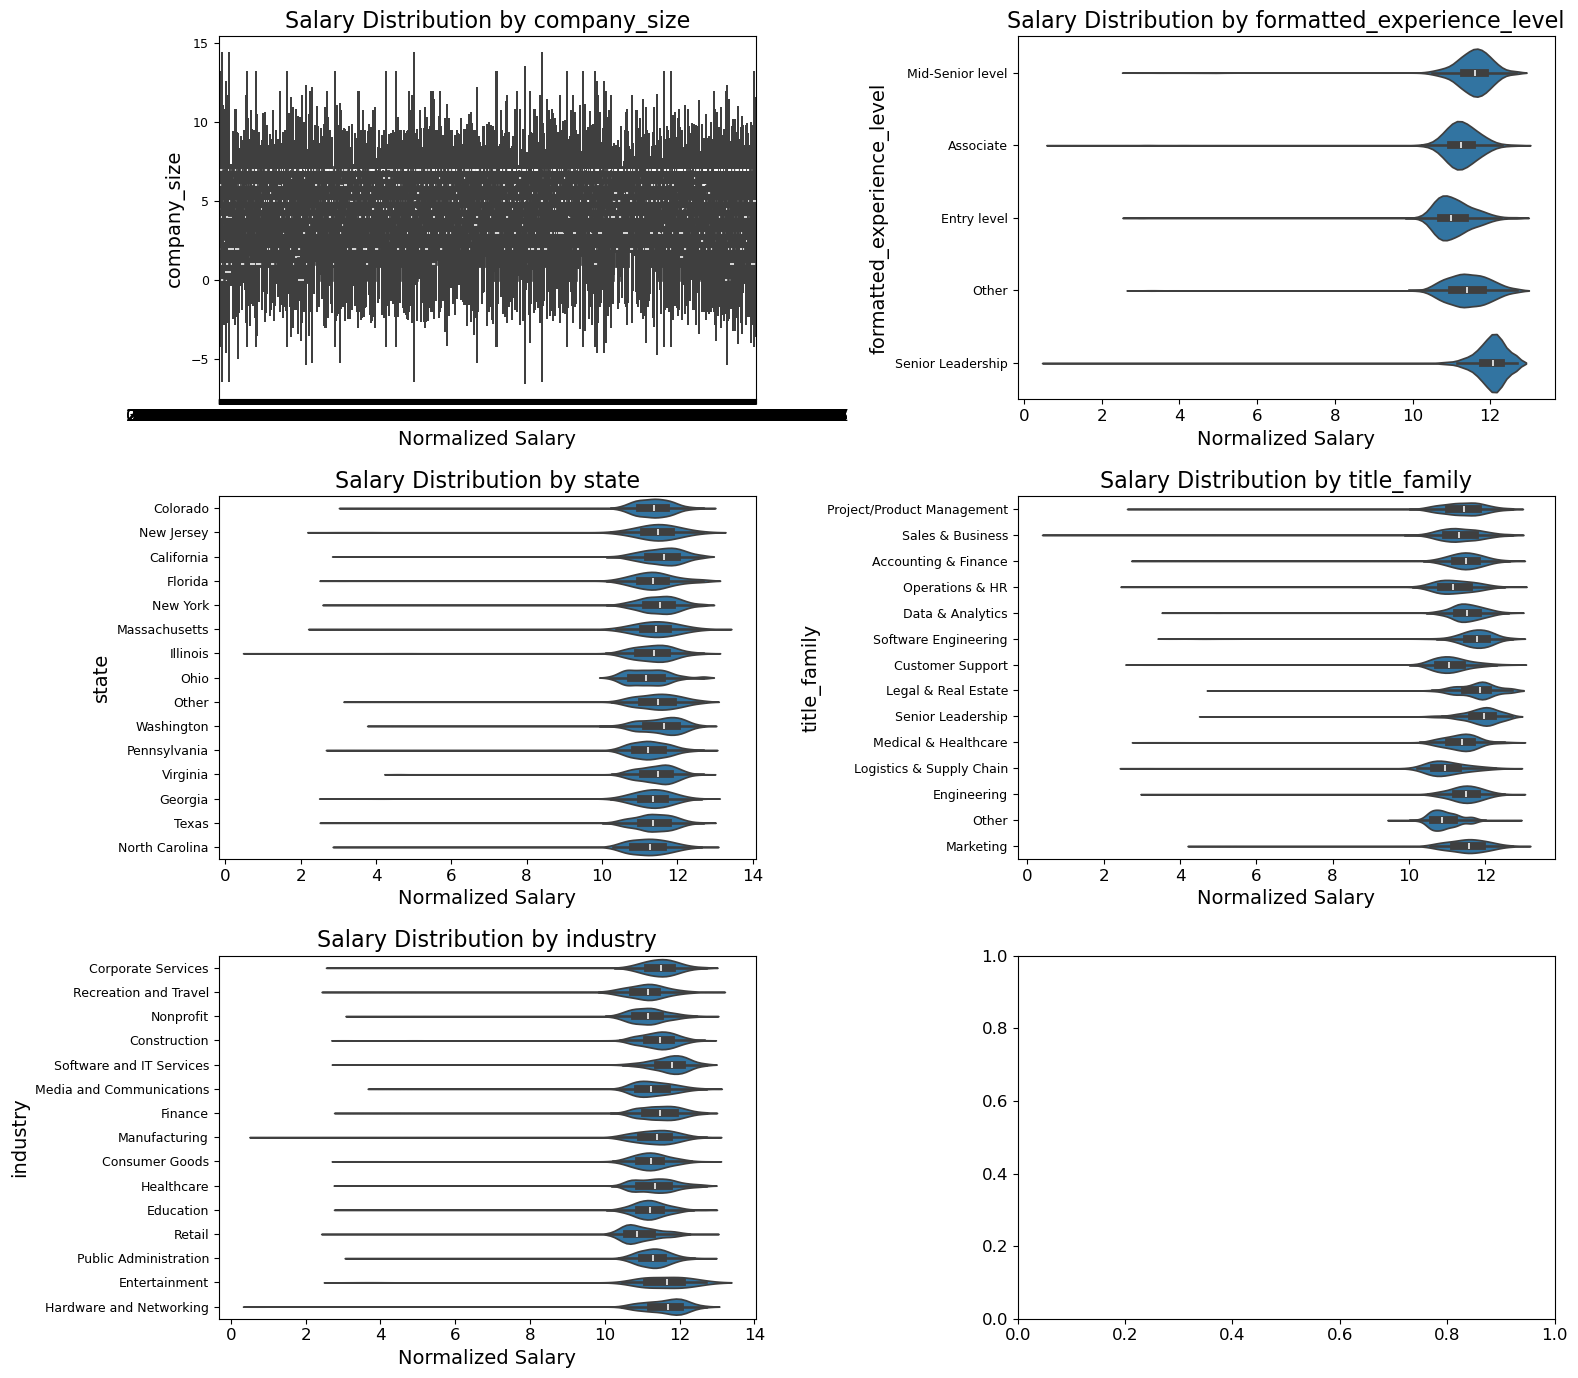

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))  # Adjust grid size
axes = axes.flatten()

for i, col in enumerate(multi_lvl_cols):
    ax = axes[i]
    
    # top 15
    top_categories = df_transformed[col].value_counts().index[:15]

    sns.violinplot(data=df_transformed[df_transformed[col].isin(top_categories)], 
                   y=col, x="normalized_salary", ax=ax)

    ax.set_title(f"Salary Distribution by {col}")
    ax.set_xlabel("Normalized Salary")
    ax.set_ylabel(col)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

plt.tight_layout()
plt.show()


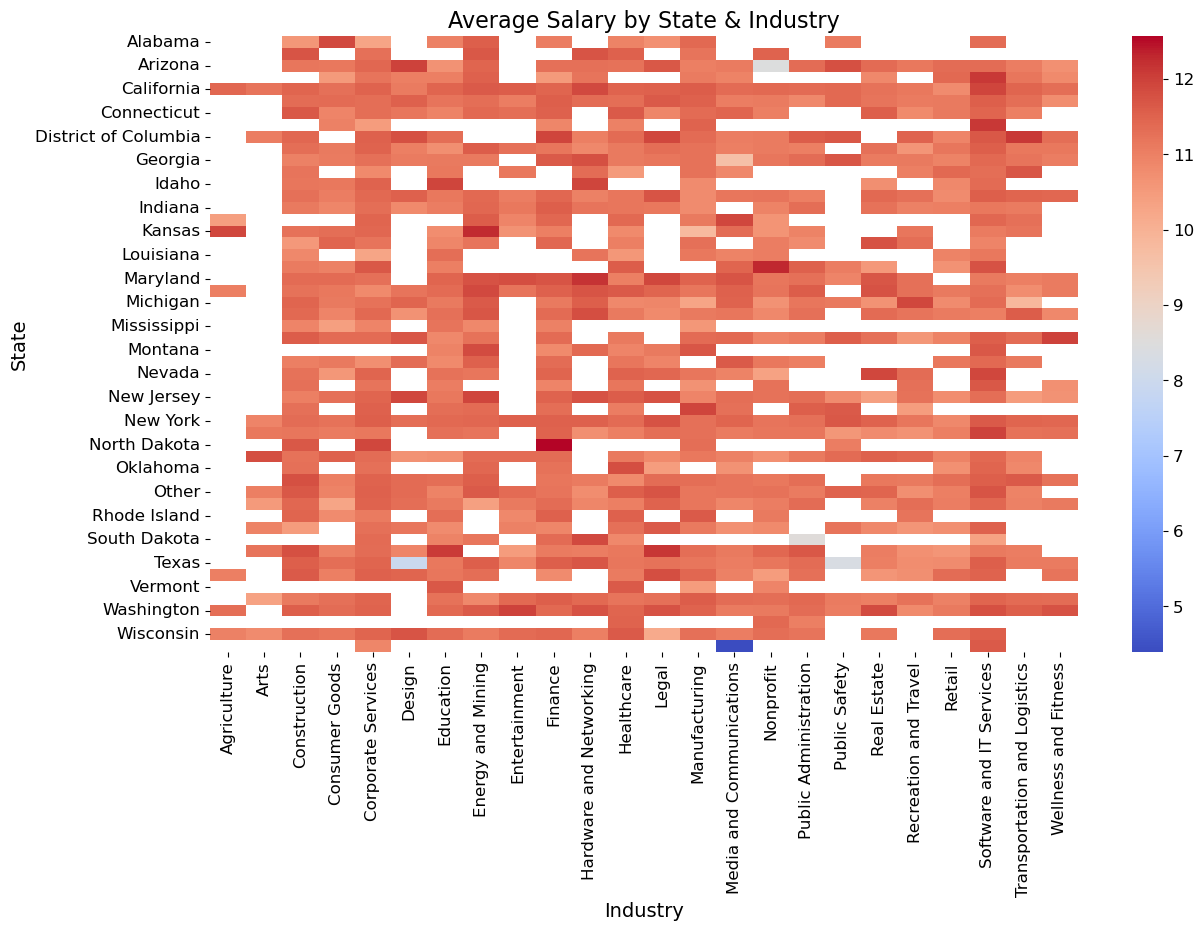

In [33]:
# state vs. industry
pivot_table = df_transformed.pivot_table(index="state", columns="industry", values="normalized_salary", aggfunc="mean")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap="coolwarm", annot=False)  # Change annot=True for numbers
plt.title("Average Salary by State & Industry")
plt.xlabel("Industry")
plt.ylabel("State")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

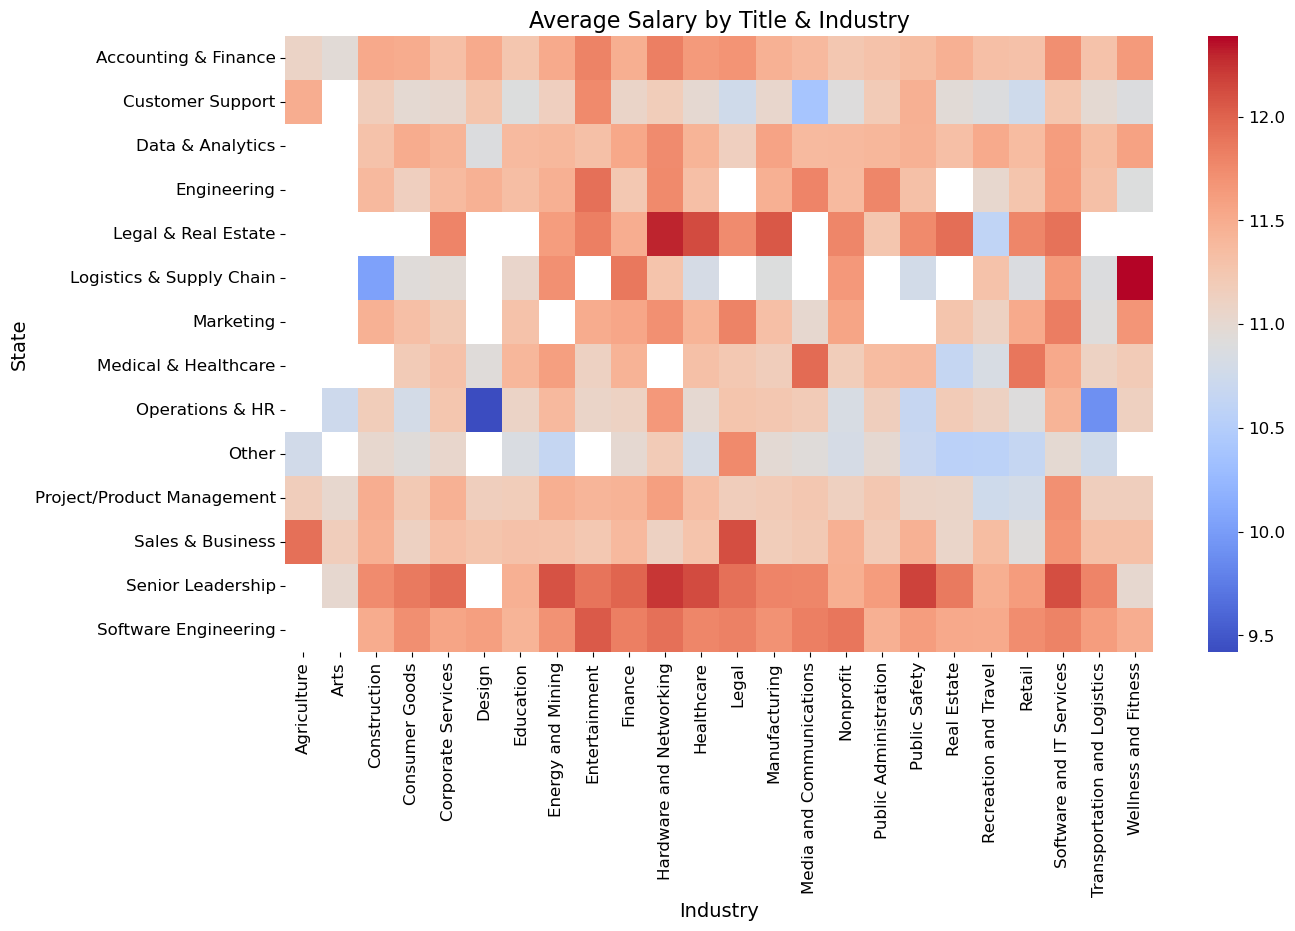

In [34]:
# title_family vs. industry
pivot_table = df_transformed.pivot_table(index="title_family", columns="industry", values="normalized_salary", aggfunc="mean")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap="coolwarm", annot=False) 
plt.title("Average Salary by Title & Industry")
plt.xlabel("Industry")
plt.ylabel("State")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Change the level order of Categorical Variables (Setting the ambiguous ones to be the first)

In [ ]:
from pandas.api.types import CategoricalDtype

# save for tracking future "drop first" 
first_categories = {
    "title_family": "Other",
    "company_size": 0,
    "formatted_experience_level": "Other",
    "industry": "Arts",
    "state": "Other"
}

for col, first_cat in first_categories.items():
    df_transformed[col] = df_transformed[col].astype(CategoricalDtype(
        categories=[first_cat] + [c for c in df_transformed[col].unique() if c != first_cat],
        ordered=True
    ))

Sandardization

In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_cols = df_transformed.select_dtypes(include=['number']).columns
non_dummy_cols = [col for col in numerical_cols if df_transformed[col].nunique() > 2]

df_not_transformed = df_transformed.copy() # for "Benefit Model" because treatment
df_not_transformed_1 = df_transformed.copy() # for "Experienc Level Model"

scaler = StandardScaler()
df_transformed[non_dummy_cols] = scaler.fit_transform(df_transformed[non_dummy_cols])
df_transformed.describe()

views       applies  remote_allowed  normalized_salary  \
count  2.943800e+04  2.943800e+04    29438.000000       2.943800e+04   
mean   2.935050e-16  4.634289e-17        0.135709      -9.307197e-16   
std    1.000017e+00  1.000017e+00        0.342485       1.000017e+00   
min   -1.958276e+00 -4.809178e-01        0.000000      -1.250959e+01   
25%   -6.212364e-01 -4.809178e-01        0.000000      -3.914814e-01   
50%   -2.301774e-01 -4.809178e-01        0.000000       6.753717e-02   
75%    3.544226e-01  3.024614e-01        0.000000       5.101940e-01   
max    6.922506e+00  6.970392e+00        1.000000       1.538844e+00   

       employee_count  follower_count  max_salary_in_usd  min_salary_in_usd  \
count    2.943800e+04    2.943800e+04       2.943800e+04       2.943800e+04   
mean    -1.776478e-16   -4.711527e-16       2.317145e-17      -3.070217e-16   
std      1.000017e+00    1.000017e+00       1.000017e+00       1.000017e+00   
min     -2.481762e+00   -4.305705e+00      -2.564329e+00      -2.496373e+00   
25%     -7.920859e-01   -6.247309e-01       1.857568e-01      -7.287099e-02   
50%      8.226105e-02    4.823133e-03       5.045362e-01       5.064933e-01   
75%      8.060093e-01    6.351491e-01       6.195391e-01       6.266633e-01   
max      2.251402e+00    2.527009e+00       8.868941e-01       8.615614e-01   

       max_hourly_salary_in_usd  min_hourly_salary_in_usd        401(k)  \
count              2.943800e+04              2.943800e+04  29438.000000   
mean               7.627268e-17              7.723815e-17      0.257388   
std                1.000017e+00              1.000017e+00      0.437203   
min               -5.847594e+00             -5.707904e+00      0.000000   
25%               -5.789043e-01             -5.334368e-01      0.000000   
50%                1.901378e-02              4.696095e-02      0.000000   
75%                5.879973e-01              5.675219e-01      1.000000   
max                1.276642e+01              1.378962e+01      1.000000   

       Medical insurance  Vision insurance  CompApplication  \
count       29438.000000      29438.000000     29438.000000   
mean            0.139649          0.136354         0.156906   
std             0.346629          0.343170         0.363718   
min             0.000000          0.000000         0.000000   
25%             0.000000          0.000000         0.000000   
50%             0.000000          0.000000         0.000000   
75%             0.000000          0.000000         0.000000   
max             1.000000          1.000000         1.000000   

       job_posting_duration  
count          2.943800e+04  
mean          -2.221562e-15  
std            1.000017e+00  
min           -3.588117e+00  
25%           -2.024133e-01  
50%           -2.024133e-01  
75%           -2.024133e-01  
max            4.628026e+00

## Causal Analysis

#### Identification
Dag (After researching and refining it until it finally made sense)

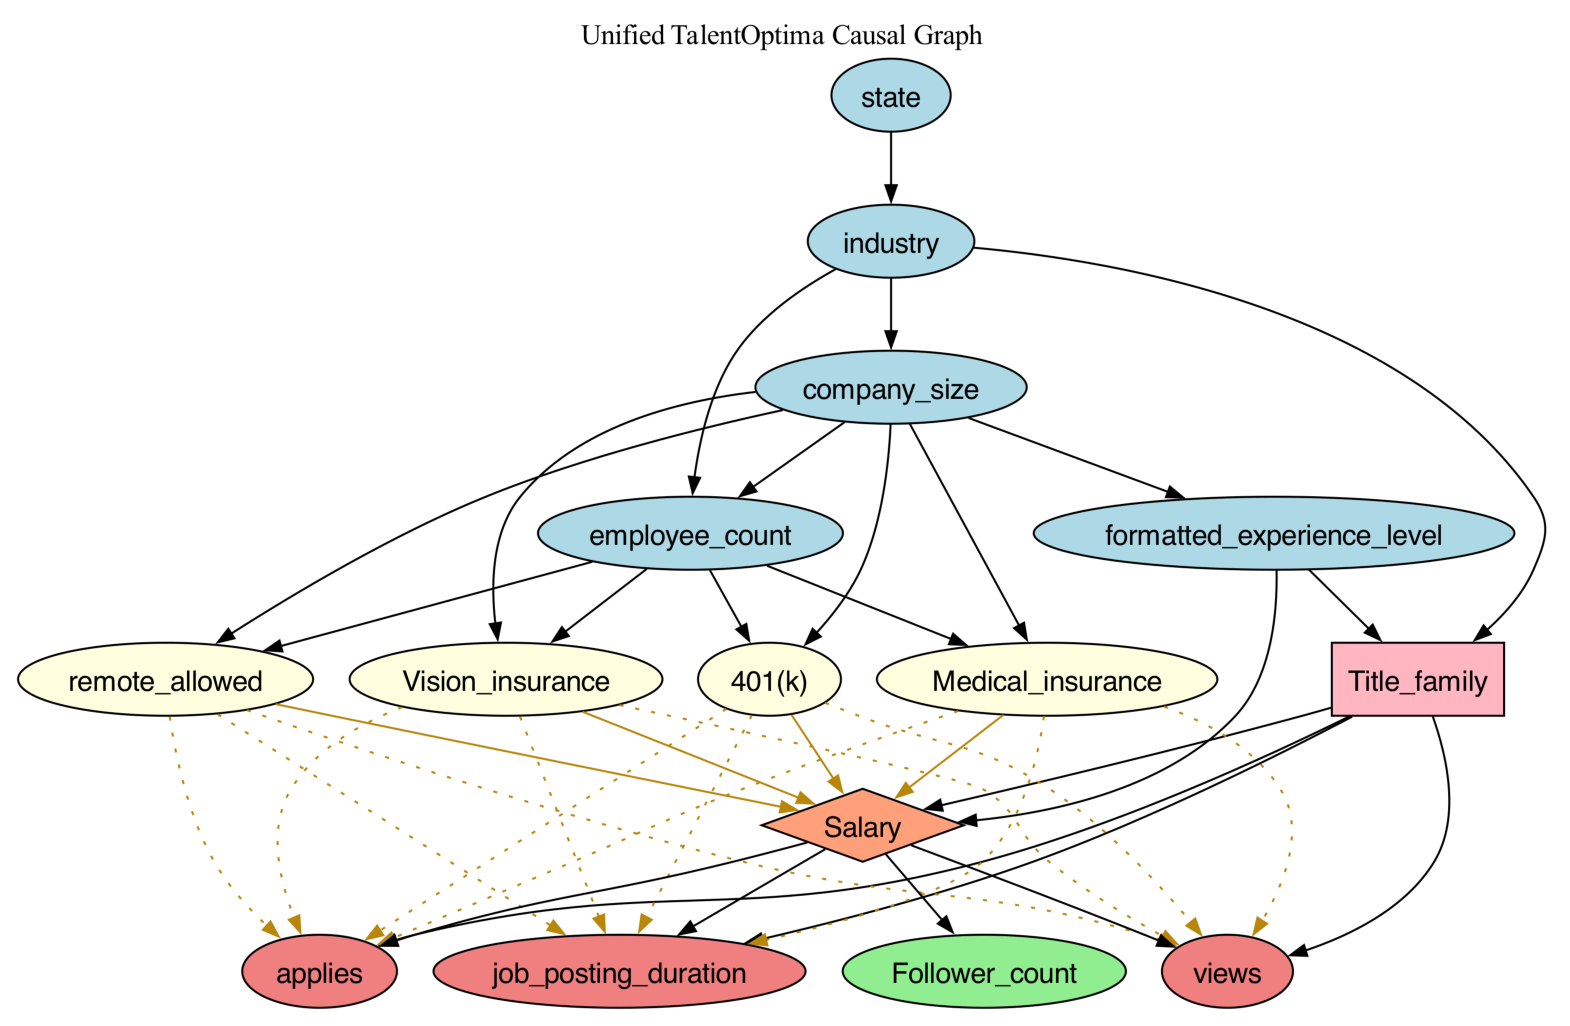

In [ ]:
import pygraphviz as pgv

causal_graph = """
digraph {
    rankdir=TB; // Top to Bottom layout for readability
    
    ///////////////////////////////
    // Define Node Styles
    ///////////////////////////////
    
    // Confounders (Common Causes, Light Blue)
    node [shape=ellipse, style=filled, fillcolor=lightblue]
    state; industry; company_size; employee_count; formatted_experience_level;

    // Treatments (Pink)
    node [shape=box, style=filled, fillcolor=lightpink]
    Title_family;

    // Benefits (Yellow)
    node [shape=ellipse, style=filled, fillcolor=lightyellow]
    remote_allowed; "401(k)"; Medical_insurance; Vision_insurance;

    // Outcomes (Orange)
    node [shape=diamond, style=filled, fillcolor=lightsalmon]
    Salary;

    // Mediators (Green)
    node [shape=ellipse, style=filled, fillcolor=lightgreen]
    Follower_count;

    // Colliders (Red)
    node [shape=ellipse, style=filled, fillcolor=lightcoral]
    job_posting_duration; views; applies;

    ///////////////////////////////
    // Confounder Links
    ///////////////////////////////
    state -> industry;
    industry -> company_size;
    industry -> employee_count;
    company_size -> employee_count; // Company Size Affects Employee Count
    company_size -> formatted_experience_level;
    company_size -> remote_allowed;
    employee_count -> remote_allowed;
    company_size -> "401(k)";
    company_size -> Medical_insurance;
    company_size -> Vision_insurance;
    employee_count -> "401(k)";
    employee_count -> Medical_insurance;
    employee_count -> Vision_insurance;

    // Experience Level as a Confounder
    formatted_experience_level -> Title_family;
    formatted_experience_level -> Salary;

    // Industry Now Affects Job Titles
    industry -> Title_family;

    ///////////////////////////////
    // Benefits --> Salary (Solid Line)
    ///////////////////////////////
    remote_allowed -> Salary [color=darkgoldenrod];
    "401(k)" -> Salary [color=darkgoldenrod];
    Medical_insurance -> Salary [color=darkgoldenrod];
    Vision_insurance -> Salary [color=darkgoldenrod];

    ///////////////////////////////
    // Benefits --> Engagement Metrics (Dotted Line)
    ///////////////////////////////
    remote_allowed -> job_posting_duration [style=dotted, color=darkgoldenrod];
    remote_allowed -> views [style=dotted, color=darkgoldenrod];
    remote_allowed -> applies [style=dotted, color=darkgoldenrod];

    "401(k)" -> job_posting_duration [style=dotted, color=darkgoldenrod];
    "401(k)" -> views [style=dotted, color=darkgoldenrod];
    "401(k)" -> applies [style=dotted, color=darkgoldenrod];

    Medical_insurance -> job_posting_duration [style=dotted, color=darkgoldenrod];
    Medical_insurance -> views [style=dotted, color=darkgoldenrod];
    Medical_insurance -> applies [style=dotted, color=darkgoldenrod];

    Vision_insurance -> job_posting_duration [style=dotted, color=darkgoldenrod];
    Vision_insurance -> views [style=dotted, color=darkgoldenrod];
    Vision_insurance -> applies [style=dotted, color=darkgoldenrod];

    ///////////////////////////////
    // Treatment --> Outcome
    ///////////////////////////////
    Title_family -> Salary;

    ///////////////////////////////
    // Mediators (Do Not Control!)
    ///////////////////////////////
    Salary -> Follower_count;

    ///////////////////////////////
    // Colliders (Post-Treatment Variables)
    ///////////////////////////////
    Salary -> job_posting_duration;
    Salary -> views;
    Salary -> applies;
    Title_family -> job_posting_duration;
    Title_family -> views;
    Title_family -> applies;
}
"""

G = pgv.AGraph(string=causal_graph)

G.graph_attr.update(dpi="300", label="Unified TalentOptima Causal Graph", labelloc="t")
G.node_attr.update(style="filled", fontname="Helvetica")
G.edge_attr.update(fontname="Helvetica", arrowsize=0.8)

plt.figure(figsize=(20, 15))
G.layout(prog="dot")  # hierarchical
G.draw("unified_dag_dotted_solid.png")
plt.imshow(plt.imread("unified_dag_dotted_solid.png"))
plt.axis('off')
plt.show()


### Identification - Experimental Design
  
##### **Benefit Model**

"How do salary and benefits independently affect engagement (applies)?"

This question is a key concern for HR professionals and employers, as it directly impacts budget allocation and recruitment strategy. Identifying which benefits boost engagement without requiring salary increases enables employers to:

- Optimize job descriptions by highlighting the most valuable benefits for specific roles or regions.
- Allocate HR budgets more efficiently to maximize engagement.
- Understand the trade-offs between salary and benefits to attract the right talent.

For job seekers, knowing how benefits influence job applications helps them identify companies that align with their priorities and negotiate better compensation.

1. Indentification: Mediation Analysis

   We hypothesize that benefits affect job applications both directly and indirectly through salary. Instead of blocking the salary pathway, we decompose the total effect into:

   - Direct Effect: The independent impact of benefits on applications, regardless of salary (benefits --> engagement).
   - Indirect Effect: The effect of benefits on applications through salary (benefits --> salary --> engagement).
  
  This distinction is critical for hiring strategy:
   - If the direct effect is strong, benefits alone drive engagement, even without salary increases.
   - If the indirect effect dominates, benefits work primarily through salary adjustments.
   - If both effects are significant, employers must find the right balance between offering direct benefits and salary adjustments.

1. Estimation: OLS Models (OLS is ideal here because we need interpretable coefficient estimates)
   
   1. Estimate the Total Effect: 

   Estimate the **Total Effect** of benefits on applications by running a regression without controlling for salary:

   $$
   Applies_i = \alpha_0 + \alpha_1 \cdot Benefit_i + \alpha_2 \cdot Confounders_i + \epsilon_i
   $$

   - **α₁**: the total effect of benefits on engagement.

   1. Estimate the Indirect Effect (Mediation)

   Estimate how **benefits influence salary**, which in turn affects applications.

   2.1 Regress Salary on Benefits 
      $$
      Salary_i = \beta_0 + \beta_1 \cdot Benefit_i + \beta_2 \cdot Confounders_i + \epsilon_i
      $$

      - **β₁** = how much benefits increase salary

   2.2 Regress Applications on Both Salary and Benefits
   
      $$
      Applies_i = \gamma_0 + \gamma_1 \cdot Salary_i + \gamma_2 \cdot Benefit_i + \gamma_3 \cdot Confounders_i + \epsilon_i
      $$

      - **γ₁** = how much salary increases applications.
      - **γ₂** = **direct effect** of benefits on applications, after accounting for salary.

   --> Total Effect = Direct + Indirect Effects

      - **Indirect Effect** (via salary) = **β₁ × γ₁**
      - **Direct Effect** (benefits on applications, independent of salary) = **γ₂**

      Employers can make more informed decisions about whether to **highlight benefits directly** or **use them strategically to adjust salary competitiveness**.
   
2. Steps
   
   - Check Overlap + MAthching (PSM & SMD Analysis)

   - Mediation Analysis: Isolating the Pure Benefit Effects
      - Total Effect: Estimate benefits --> applications impact.
      - Indirect Effect: Estimate benefits --> salary --> applications impact.
      - Direct Effect: Estimate benefits --> applications impact independent of salary.
   - HTE 
     - T-Learner + XGBoost to measure CATE 
     - Identify which subgroups (industries, experience levels, job titles...) benefit most from each benefit.
   - Robustness: Testing the Validity of Our Findings
     - Random Common Cause: Introduces a fake confounder to test model sensitivity.
     - Placebo Test: Replaces benefits with random noise to ensure true causality.
     - Data Subset Refuter: Checks consistency when using only 90% of the data.

3. Key Variables
   
   - Outcome: Engagement Metrics (applies)
   - Treatment: Binary indicator for each benefit (remote_allowed, 401(k), Medical insurance, Vision insurance)
   - Confounders: company_size, formatted_experience_level, state, title_family, industry, employee_count
   - Post-treatment: job_posting_duration, views, follower_count (Do not include them!!!)

4. Findings
   
   - Remote work significantly increases applications in tech-related jobs.
   - employee_count is the most important variable no matter in terms of which benefit treatment
   - employee_count has high shap dependence with experience level
   - For lower salaries (~3-6): CATE varies more, with some negative effects --> offering benefits alone may not always compensate for lower salaries
   - For higher salaries (~10-12): Data points cluster around CATE = 0 --> benefits have limited additional impact on engagement at high salary levels
   - Highly positive CATE (dark red cells):
     - Consumer Goods industry & Customer Support (1.72)
     - Nonprofit industry & Engineering (1.70)
     - Manufacturing industry & Medical & Healthcare (2.03)
     - Design & SoftWare Engineering (1.30)
      --> Employees in these industry-title pairs benefit the most from the tested interventions, leading to an increased probability of application.
   - Media & Communication: Employees in these fields may value benefits like remote work or health insurance more, especailly from data professionals.
   - For Project/Product Management Positions:
     - Manufacturing & Media/Communications: Benefits increase applications, suggesting alignment with job expectations.
     - Public Administration: Slightly negative effect, which might mean employees in government roles either already have strong benefits or find them less relevant.

#### Estimation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from scipy.stats import norm
from tabulate import tabulate
from causalml.inference.meta import BaseTRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Define key variables
benefits = ['remote_allowed', '401(k)', 'Medical insurance', 'Vision insurance']  # Add all benefits you want to test
outcome_col = "applies"
mediator_col = "normalized_salary"
confounders = ['company_size', 'state', 'industry', 'title_family', 'formatted_experience_level', 'employee_count']

# one-hot encoding
df_encoded = pd.get_dummies(
    df_not_transformed, 
    columns=['company_size', 'state', 'industry', 'title_family', 'formatted_experience_level'], 
    drop_first=True
)

# updated confounders after dummified
dummy_confounders = [col for col in df_encoded.columns if any(base in col for base in confounders)]

# SMD func
def compute_smd(df, treatment_col, covariates):
    smd_results = {}
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]

    for cov in covariates:
        if cov in df.columns: # for debugging
            mean_treated = treated[cov].mean()
            mean_control = control[cov].mean()
            std_treated = treated[cov].std()
            std_control = control[cov].std()
            smd = abs(mean_treated - mean_control) / np.sqrt((std_treated**2 + std_control**2) / 2)
            smd_results[cov] = smd
        else:
            print(f"Warning: {cov} not found in dataframe. Skipping.")

    return pd.DataFrame(smd_results.items(), columns=["Covariate", "SMD"])

# PSM func
def perform_matching(df, treatment_col, confounders):
    
    X = df[confounders]
    y = df[treatment_col]

    # train Logistic Regression for PS
    propensity_model = LogisticRegression(max_iter=1000, solver='liblinear')
    df_matched = df.copy()
    df_matched["propensity_score"] = propensity_model.fit(X, y).predict_proba(X)[:, 1]

    # check Common Support  (Drop Extreme Propensity Scores)
    prop_score_min = max(df_matched[df_matched[treatment_col] == 1]["propensity_score"].min(),
                         df_matched[df_matched[treatment_col] == 0]["propensity_score"].min())

    prop_score_max = min(df_matched[df_matched[treatment_col] == 1]["propensity_score"].max(),
                         df_matched[df_matched[treatment_col] == 0]["propensity_score"].max())

    df_matched = df_matched[
        (df_matched["propensity_score"] >= prop_score_min) &
        (df_matched["propensity_score"] <= prop_score_max)
    ]

    # NN matching
    treated = df_matched[df_matched[treatment_col] == 1]
    control = df_matched[df_matched[treatment_col] == 0]

    nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    nn.fit(control[["propensity_score"]])

    _, indices = nn.kneighbors(treated[["propensity_score"]])
    matched_control = control.iloc[indices.flatten()].copy()

    # prevent duplicates when Matching
    matched_control["matched"] = 1  # tracking indicator
    treated["matched"] = 1

    matched_df = pd.concat([treated, matched_control])
    
    return matched_df

# mediation analysis func
def perform_mediation_analysis(matched_df, treatment_col, outcome_col, mediator_col, confounders):
    # debug: convert boolean
    bool_cols = matched_df.select_dtypes(include=['bool']).columns
    matched_df[bool_cols] = matched_df[bool_cols].astype(int)  

    # debug: reset index to avoid issues
    matched_df = matched_df.reset_index(drop=True)

    # treatment -> Salary
    model_mediator = sm.OLS(
        matched_df[mediator_col], 
        sm.add_constant(matched_df[[treatment_col] + confounders])
    ).fit()
    beta1 = model_mediator.params[treatment_col]

    # total effect
    model_total = sm.OLS(
        matched_df[outcome_col], 
        sm.add_constant(matched_df[[treatment_col] + confounders])
    ).fit()
    total_effect = model_total.params[treatment_col]

    # direct effect (treatment -> applies controlling for salary)
    model_final = sm.OLS(
        matched_df[outcome_col], 
        sm.add_constant(matched_df[[mediator_col, treatment_col] + confounders])
    ).fit()
    gamma1 = model_final.params[mediator_col]
    gamma2 = model_final.params[treatment_col]

    # indirect effect
    indirect_effect = beta1 * gamma1
    direct_effect = gamma2

    return {
        'effect_on_mediator': beta1,
        'mediator_effect_on_outcome': gamma1,
        'direct_effect': direct_effect,
        'indirect_effect': indirect_effect,
        'total_effect': total_effect,
        'calculated_total': direct_effect + indirect_effect
    }

# T-Learner CATE estimate (5-fold cv)
def estimate_cate(matched_df, treatment_col, outcome_col, confounders):

    X = matched_df[confounders]
    y = matched_df[outcome_col]
    T = matched_df[treatment_col].astype(int)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # store CATE predictions
    cate_predictions = np.zeros(len(matched_df))

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        T_train, T_val = T.iloc[train_idx], T.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        t_learner = BaseTRegressor(learner=XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
        t_learner.fit(X_train, T_train, y_train)
        cate_predictions[val_idx] = t_learner.predict(X_val).ravel()

    matched_df["CATE"] = cate_predictions
    
    return matched_df

# results container
results = {}

for benefit in benefits:
    print(f"\n{'='*50}")
    print(f"Analyzing benefit: {benefit}")
    print(f"{'='*50}\n")
    
    smd_before = compute_smd(df_encoded, benefit, dummy_confounders)
    print("SMD Before Matching Summary:")
    print(f"Extreme imbalance (SMD > 1): {len(smd_before[smd_before.SMD > 1])}")
    print(f"Some imbalance (SMD > 0.1): {len(smd_before[smd_before.SMD > 0.1])}")
    print(f"Large imbalance (SMD > 0.25): {len(smd_before[smd_before.SMD > 0.25])}")
    
    matched_df = perform_matching(df_encoded, benefit, dummy_confounders)
    
    smd_after = compute_smd(matched_df, benefit, dummy_confounders)
    print("\nSMD After Matching Summary:")
    print(f"Extreme imbalance (SMD > 1): {len(smd_after[smd_after.SMD > 1])}")
    print(f"Some imbalance (SMD > 0.1): {len(smd_after[smd_after.SMD > 0.1])}")
    print(f"Large imbalance (SMD > 0.25): {len(smd_after[smd_after.SMD > 0.25])}")
    
    num_treated = matched_df[matched_df[benefit] == 1].shape[0]
    num_control = matched_df[matched_df[benefit] == 0].shape[0]
    print(f"\nMatched Sample: {num_treated} treated, {num_control} control")
    
    mediation_results = perform_mediation_analysis(
        matched_df, benefit, outcome_col, mediator_col, dummy_confounders
    )
    
    print("\nMeditation Analysis Results:")
    print(f"Effect of {benefit} on {mediator_col}: {mediation_results['effect_on_mediator']:.4f}")
    print(f"Effect of {mediator_col} on {outcome_col}: {mediation_results['mediator_effect_on_outcome']:.4f}")
    print(f"Direct Effect: {mediation_results['direct_effect']:.4f}")
    print(f"Indirect Effect (via {mediator_col}): {mediation_results['indirect_effect']:.4f}")
    print(f"Total Effect: {mediation_results['total_effect']:.4f}")
    print(f"Calculated Total (Direct + Indirect): {mediation_results['calculated_total']:.4f}")
    
    matched_df = estimate_cate(matched_df, benefit, outcome_col, dummy_confounders)
    
    mean_cate = matched_df["CATE"].mean()
    print(f"\nConditional Average Treatment Effect (CATE):")
    print(f"Mean CATE: {mean_cate:.4f}")
    print(f"Min CATE: {matched_df['CATE'].min():.4f}")
    print(f"Max CATE: {matched_df['CATE'].max():.4f}")
    
    results[benefit] = {
        'mediation': mediation_results,
        'cate': {
            'mean': mean_cate,
            'min': matched_df['CATE'].min(),
            'max': matched_df['CATE'].max()
        },
        'matching': {
            'treated': num_treated,
            'control': num_control
        },
        'smd_before': len(smd_before[smd_before.SMD > 0.1]),
        'smd_after': len(smd_after[smd_after.SMD > 0.1])
    }

# summary table
summary_rows = []
for benefit, res in results.items():
    summary_rows.append([
        benefit,
        res['mediation']['direct_effect'],
        res['mediation']['indirect_effect'],
        res['mediation']['total_effect'],
        res['cate']['mean'],
        f"{res['matching']['treated']} / {res['matching']['control']}",
        f"{res['smd_before']} --> {res['smd_after']}"
    ])

summary_table = pd.DataFrame(
    summary_rows,
    columns=["Benefit", "Direct Effect", "Indirect Effect", "Total Effect", 
             "Mean CATE", "Sample Size (T/C)", "Imbalanced Covariates (Before-->After)"]
)

print("\n\nSummary of All Benefits Analysis:")
print(tabulate(summary_table, headers="keys", tablefmt="pretty", showindex=False))


Analyzing benefit: remote_allowed

SMD Before Matching Summary:
Extreme imbalance (SMD > 1): 0
Some imbalance (SMD > 0.1): 23
Large imbalance (SMD > 0.25): 2

SMD After Matching Summary:
Extreme imbalance (SMD > 1): 0
Some imbalance (SMD > 0.1): 0
Large imbalance (SMD > 0.25): 0

Matched Sample: 3995 treated, 3995 control

Meditation Analysis Results:
Effect of remote_allowed on normalized_salary: 0.1592
Effect of normalized_salary on applies: -0.0149
Direct Effect: 0.5776
Indirect Effect (via normalized_salary): -0.0024
Total Effect: 0.5752
Calculated Total (Direct + Indirect): 0.5752

Conditional Average Treatment Effect (CATE):
Mean CATE: 0.5975
Min CATE: -3.0310
Max CATE: 5.0658

Analyzing benefit: 401(k)

SMD Before Matching Summary:
Extreme imbalance (SMD > 1): 0
Some imbalance (SMD > 0.1): 7
Large imbalance (SMD > 0.25): 0

SMD After Matching Summary:
Extreme imbalance (SMD > 1): 0
Some imbalance (SMD > 0.1): 0
Large imbalance (SMD > 0.25): 0

Matched Sample: 7577 treated, 7577

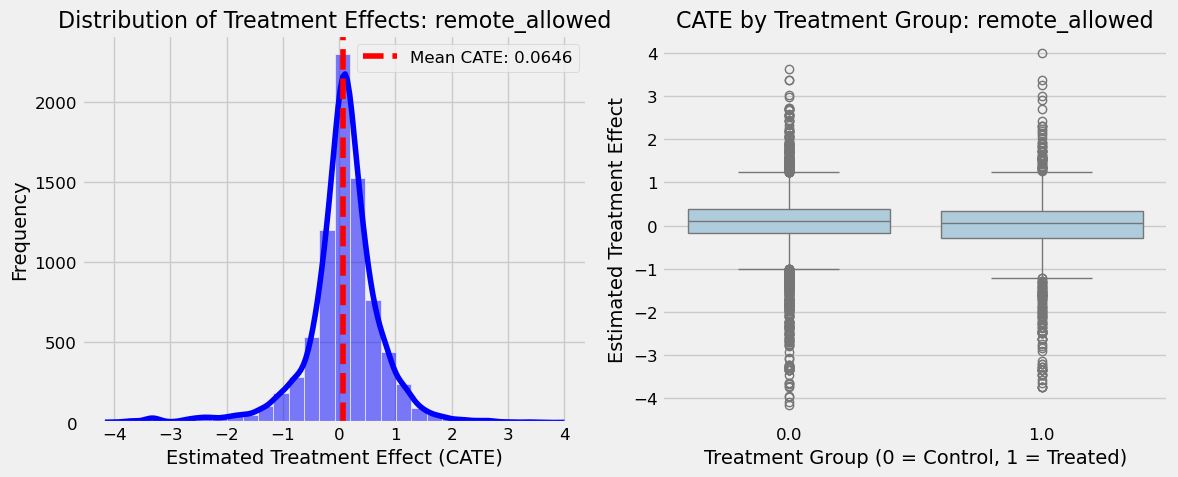

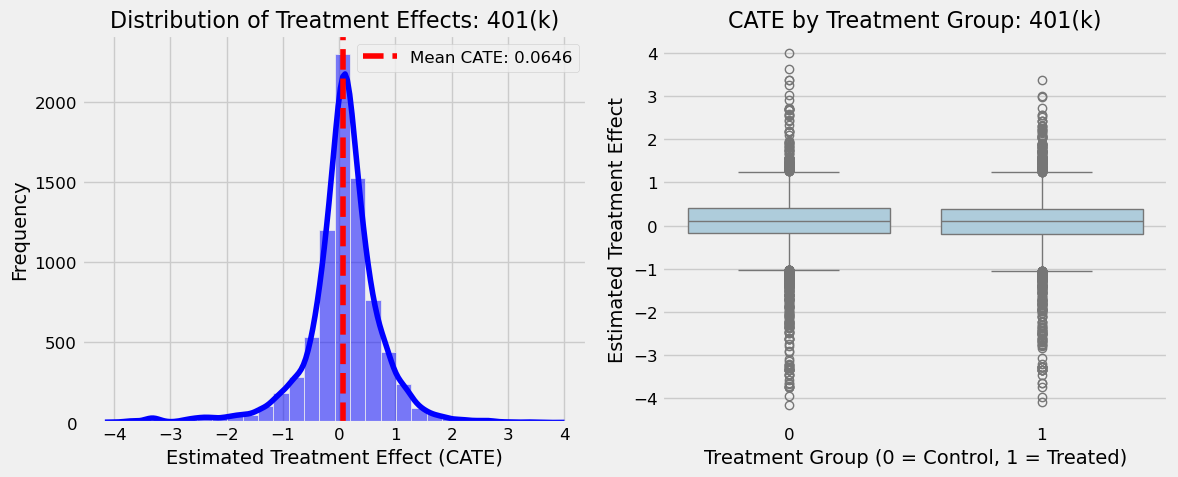

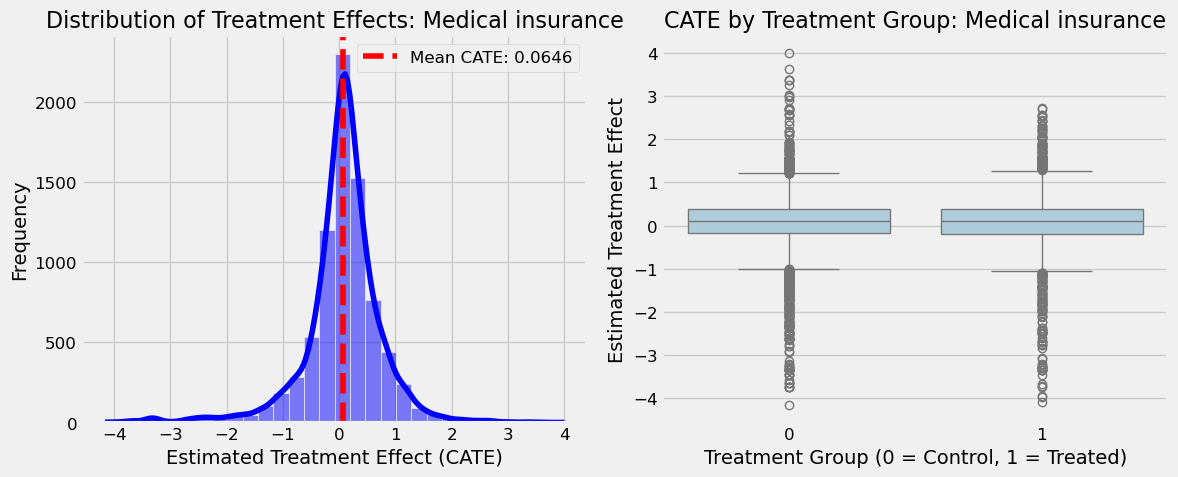

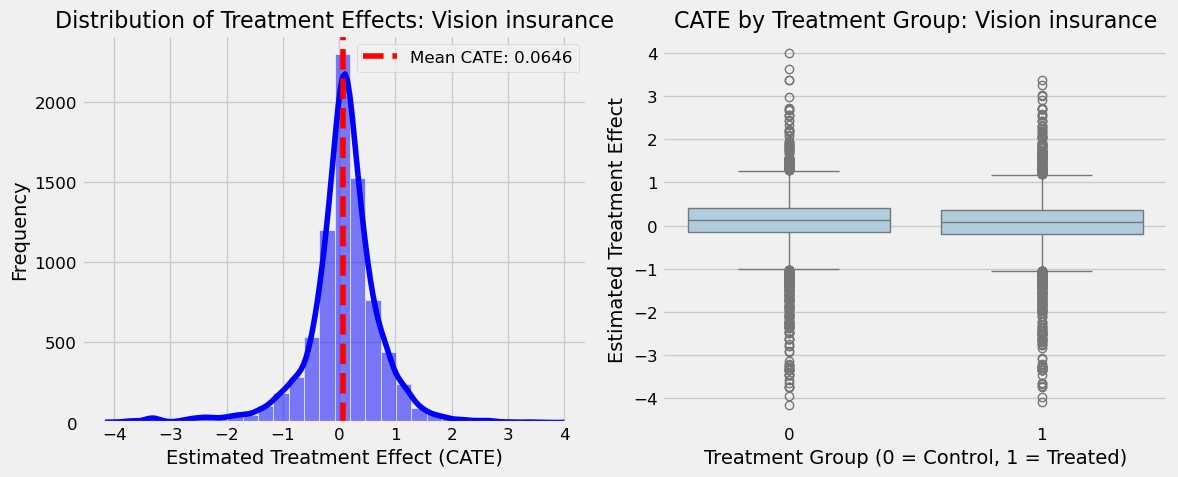

In [ ]:
# histogram + boxplot of CATE across benefit
for benefit in benefits:
    plt.figure(figsize=(12, 5))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(matched_df["CATE"], bins=30, kde=True, color="blue")
    plt.axvline(matched_df["CATE"].mean(), color="red", linestyle="--", label=f"Mean CATE: {matched_df['CATE'].mean():.4f}")
    plt.xlabel("Estimated Treatment Effect (CATE)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Treatment Effects: {benefit}")
    plt.legend()

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=matched_df[benefit], y=matched_df["CATE"])
    plt.xlabel("Treatment Group (0 = Control, 1 = Treated)")
    plt.ylabel("Estimated Treatment Effect")
    plt.title(f"CATE by Treatment Group: {benefit}")

    plt.tight_layout()
    plt.savefig(f"cate_analysis_{benefit}.png")
    plt.show()

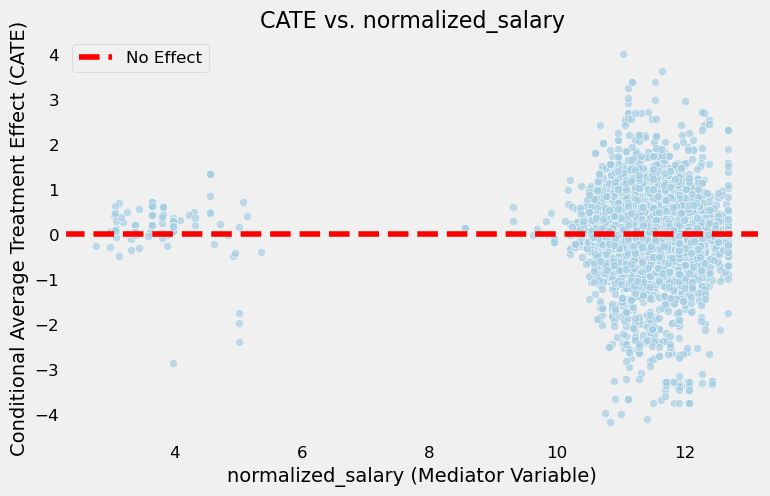

In [ ]:
# CATE vs. salary

plt.figure(figsize=(8, 5))
sns.scatterplot(x=matched_df[mediator_col], y=matched_df["CATE"], alpha=0.7)
plt.axhline(0, color="red", linestyle="--", label="No Effect")
plt.xlabel(f"{mediator_col} (Mediator Variable)")
plt.ylabel("Conditional Average Treatment Effect (CATE)")
plt.title(f"CATE vs. {mediator_col}")
plt.legend()
plt.grid()
plt.show()


- Data points are more concentrated on the right, suggesting a higher density of observations for larger salaries.
- For lower salaries (~3-6): CATE varies more, with some negative effects --> offering benefits alone may not always compensate for lower salaries
- For higher salaries (~10-12): Data points cluster around CATE = 0 --> benefits have limited additional impact on engagement at high salary levels

Treatment effects depend on salary level

- The impact of the benefit (remote work) is more heterogeneous for lower salaries, meaning some workers benefit significantly while others experience negative effects.
- For higher salaries, the effect is more stable and close to zero, indicating minimal impact.

Potential Explanation:

- Employees with lower salaries may be more affected by benefits like remote work or healthcare coverage.
- Higher earners may already have workplace flexibility or access to these benefits, leading to little to no additional effect.

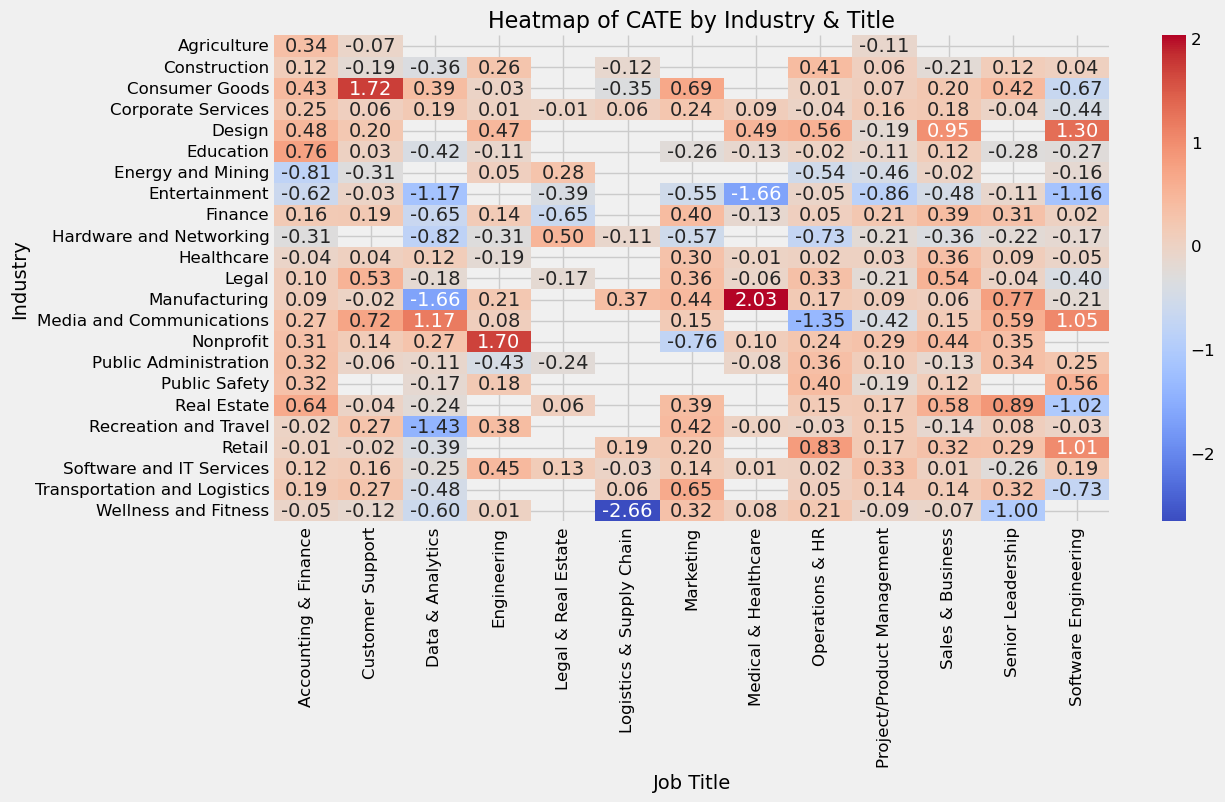

In [ ]:
# CATE by industry & title

# restore one-hot encoded labels
industry_cols = [col for col in matched_df.columns if col.startswith("industry_")]
title_cols = [col for col in matched_df.columns if col.startswith("title_family_")]

matched_df["industry"] = matched_df[industry_cols].idxmax(axis=1).str.replace("industry_", "")
matched_df["title_family"] = matched_df[title_cols].idxmax(axis=1).str.replace("title_family_", "")

heatmap_data = matched_df.pivot_table(values="CATE", index="industry", columns="title_family", aggfunc="mean")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")

plt.xlabel("Job Title")
plt.ylabel("Industry")
plt.title("Heatmap of CATE by Industry & Title")

plt.xticks(rotation=90)
plt.show()

- Highly positive CATE (dark red cells):
  - Consumer Goods industry & Customer Support (1.72)
  - Nonprofit industry & Engineering (1.70)
  - Manufacturing industry & Medical & Healthcare (2.03)
  - Design & SoftWare Engineering (1.30)

--> Employees in these industry-title pairs benefit the most from the tested interventions, leading to an increased probability of application.

Takeaways for Data & Analytics:

- Media & Communication: These benefits significantly increase applications. Employees in these fields may value benefits like remote work or health insurance more.

Project/Product Management
- Manufacturing & Media/Communications: Benefits increase applications, suggesting alignment with job expectations.
- Public Administration: Slightly negative effect, which might mean employees in government roles either already have strong benefits or find them less relevant.


Generating SHAP analysis for: remote_allowed


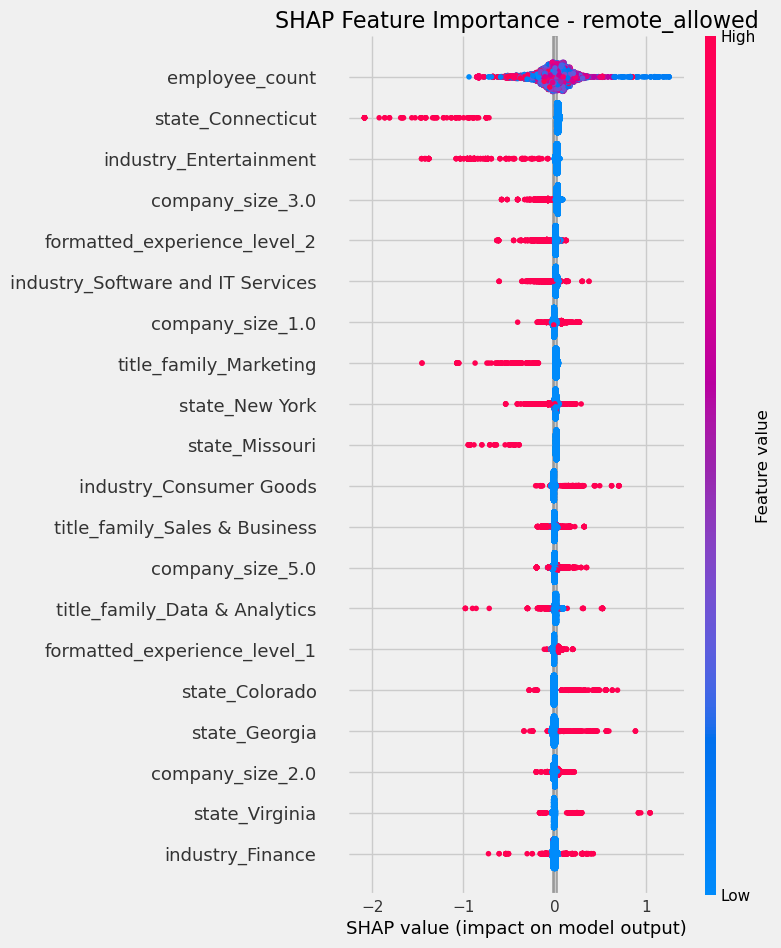

<Figure size 800x500 with 0 Axes>

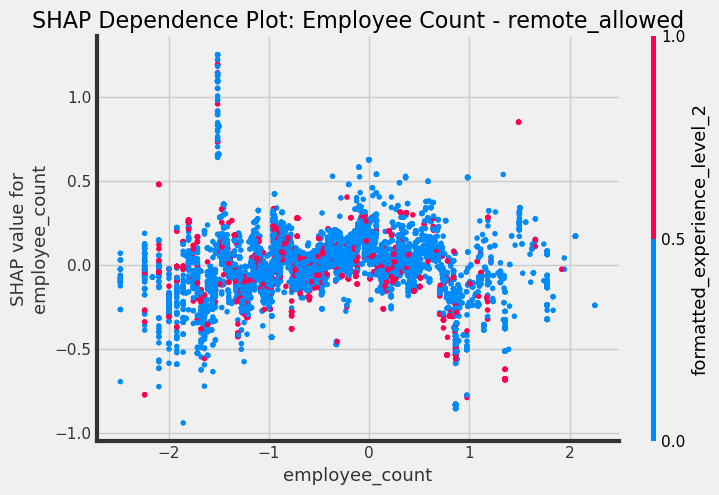


Generating SHAP analysis for: 401(k)


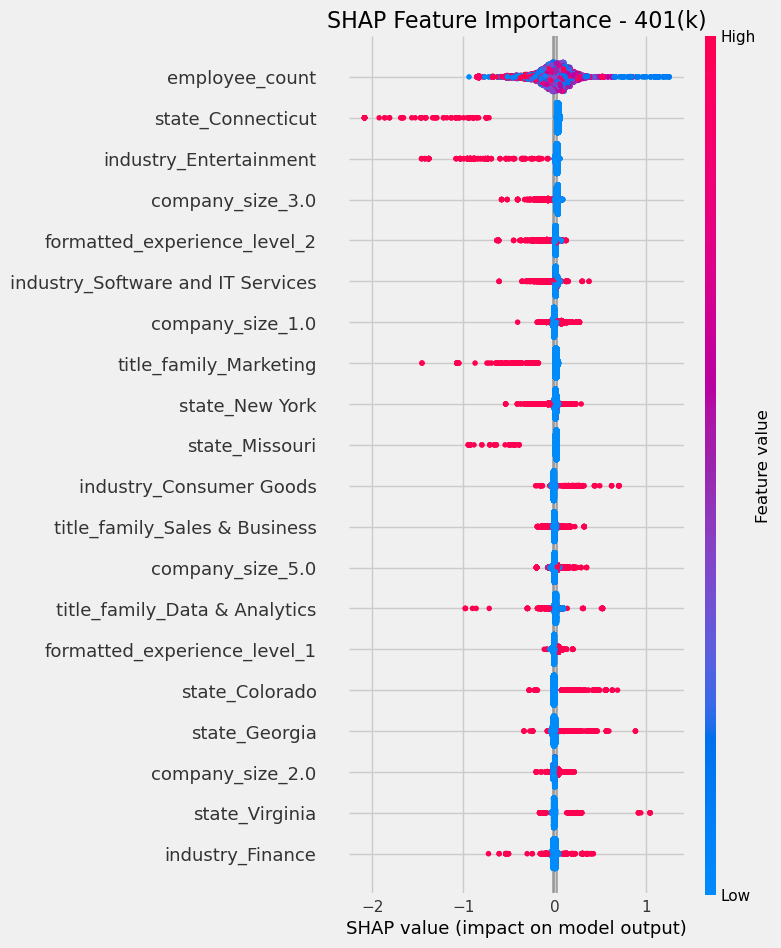

<Figure size 800x500 with 0 Axes>

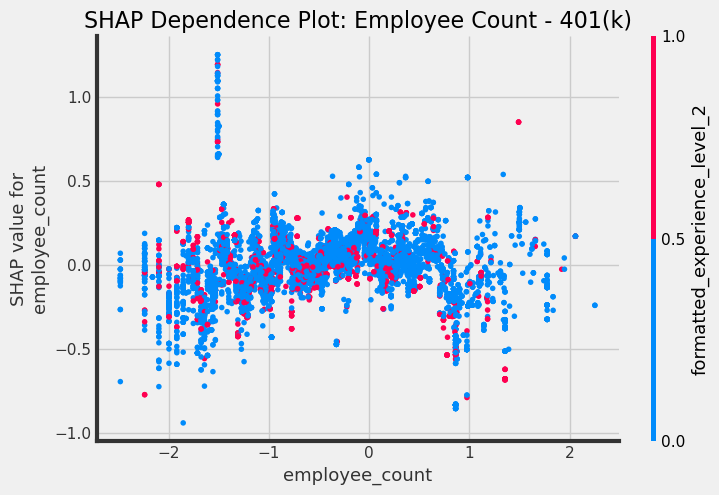


Generating SHAP analysis for: Medical insurance


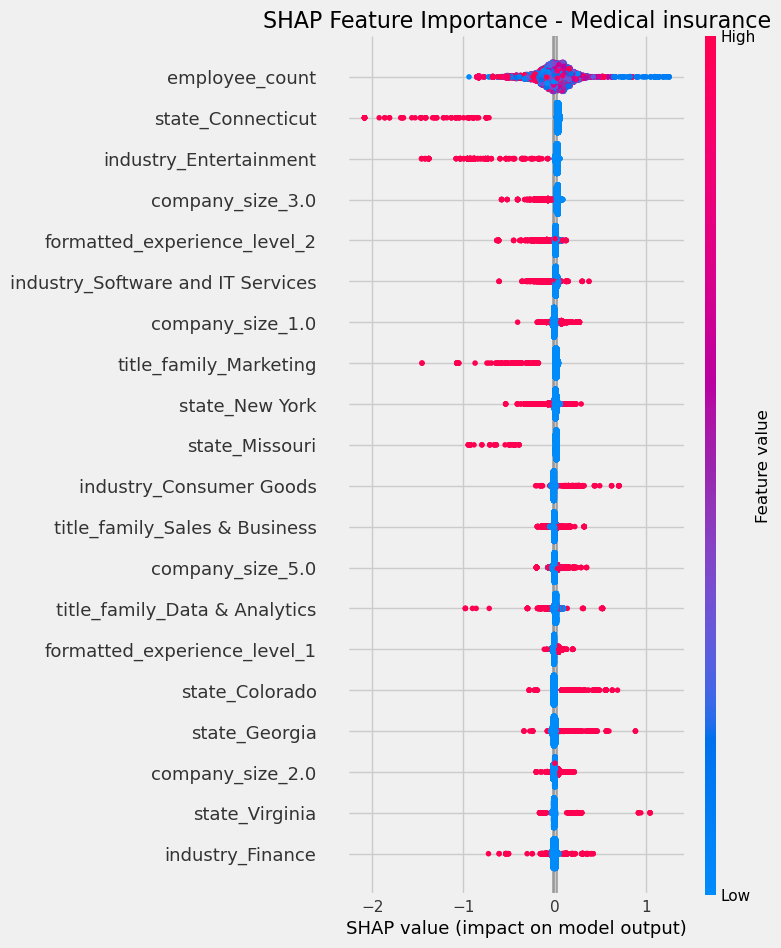

<Figure size 800x500 with 0 Axes>

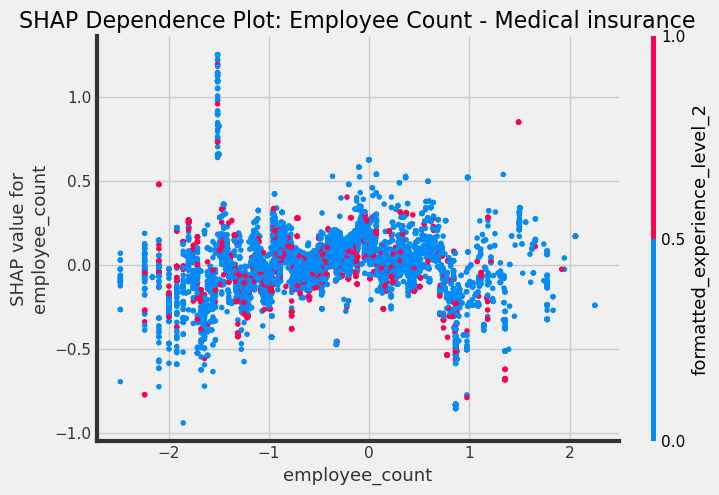


Generating SHAP analysis for: Vision insurance


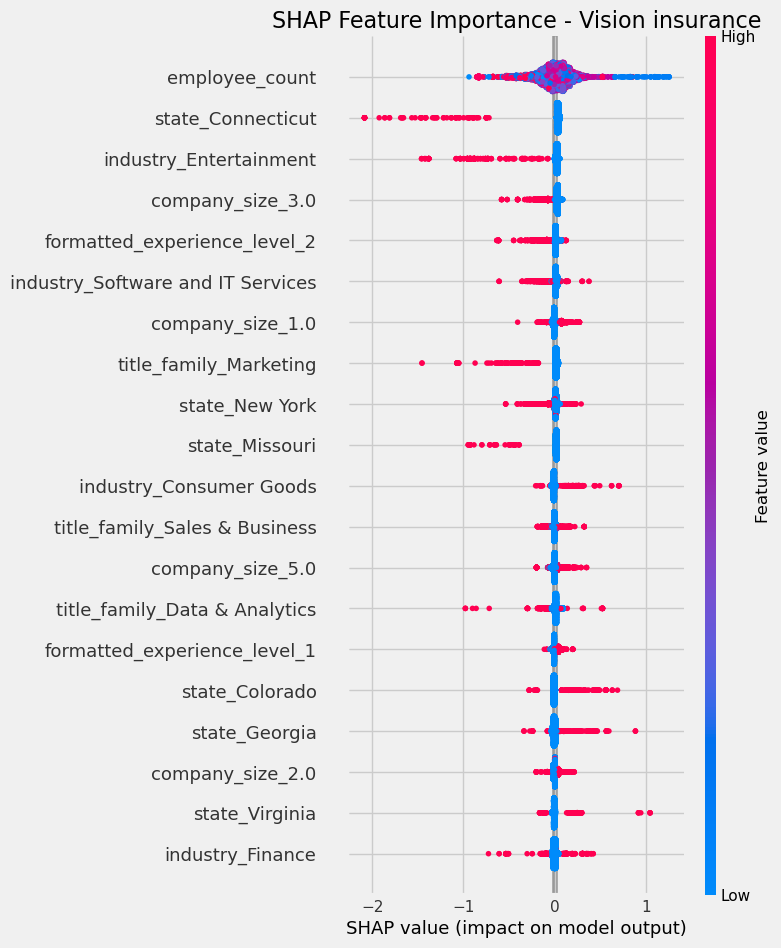

<Figure size 800x500 with 0 Axes>

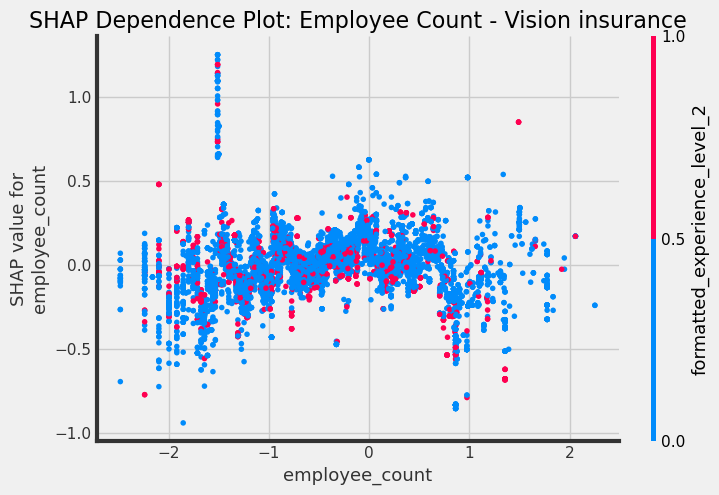

In [ ]:
# SHAP feature importance and dependence plots
import shap
import matplotlib.pyplot as plt

for benefit in benefits:
    print(f"\nGenerating SHAP analysis for: {benefit}")

    X_cate = matched_df[dummy_confounders]
    y_cate = matched_df["CATE"]

    # train the XGBoost model for CATE estimation
    cate_model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
    cate_model.fit(X_cate, y_cate)  # Fix: Only two arguments (X, y)

    explainer = shap.Explainer(cate_model, X_cate)
    shap_values = explainer(X_cate)

    # top 20 SHAP feature importance
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_cate, show=False)
    plt.title(f"SHAP Feature Importance - {benefit}") # employee_count is important
    plt.show()

    # SHAP dependence vs. employee_count
    if "employee_count" in X_cate.columns:
        plt.figure(figsize=(8, 5))
        shap.dependence_plot("employee_count", shap_values.values, X_cate, show=False)
        plt.title(f"SHAP Dependence Plot: Employee Count - {benefit}")
        plt.show()
    else:
        print(f"Warning: 'employee_count' not found in dataset for {benefit}.")


- employee_count is the most important predictor, followed by state_Connecticut, industry_Entertainment, and company_size_3.0.
- employee_count has a balanced impact with both positive and negative SHAP values, meaning it interacts with remote_allowed in complex ways.
- formatted_experience_level_2 (Mid-Senior level) appears influential, suggesting experience level affects the treatment impact.

### Sensitivity Analysis (Robustness Checks)

In [ ]:
from dowhy import CausalModel

# result container
refutation_results = []

for benefit in benefits: 
    
    model = CausalModel(
        data=df_encoded,
        treatment=benefit,
        outcome=outcome_col,  # observed outcome
        common_causes=dummy_confounders
    )

    identified_estimand = model.identify_effect()
    causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

    # random common cause
    res_random = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="random_common_cause",
        show_progress_bar=True
    )

    # placebo/permutation test
    res_placebo = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="placebo_treatment_refuter",
        placebo_type="permute",
        show_progress_bar=True
    )

    # data subset test
    res_subset = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="data_subset_refuter",
        subset_fraction=0.9,  # retain 90% of the data
        show_progress_bar=True
    )

    refutation_results.append({
        "Benefit": benefit,
        "Original Effect": causal_estimate.value,
        "Random Common Cause": res_random.new_effect,
        "Placebo Effect": res_placebo.new_effect,
        "Subset Effect": res_subset.new_effect,
        "Random Change (%)": 100 * abs(res_random.new_effect - causal_estimate.value) / abs(causal_estimate.value),
        "Placebo Change (%)": 100 * abs(res_placebo.new_effect - causal_estimate.value) / abs(causal_estimate.value),
        "Subset Change (%)": 100 * abs(res_subset.new_effect - causal_estimate.value) / abs(causal_estimate.value),
    })

refutation_summary = pd.DataFrame(refutation_results)

print("\nRefutation Summary Across Benefits:")
print(tabulate(refutation_summary, headers="keys", tablefmt="pretty", showindex=False))

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]


Refutation Summary Across Benefits:
+-------------------+----------------------+---------------------+-----------------------+----------------------+-----------------------+--------------------+---------------------+
|      Benefit      |   Original Effect    | Random Common Cause |    Placebo Effect     |    Subset Effect     |   Random Change (%)   | Placebo Change (%) |  Subset Change (%)  |
+-------------------+----------------------+---------------------+-----------------------+----------------------+-----------------------+--------------------+---------------------+
|  remote_allowed   |  0.6908030920549518  | 0.6907947013641201  | 0.002062953517294121  |  0.6915748722884923  | 0.0012146284416206627 | 99.70136880668015  | 0.11172217415018845 |
|      401(k)       | 0.027687242295725906 | 0.02767092087464515 | 0.0010187562073829517 | 0.027892284390984505 |  0.05894924783923428  | 96.32048509381444  | 0.7405652504809087  |
| Medical insurance | 0.11216525674546696  | 0.11215481802

### Identification - Experimental Design

##### **Experience Level Model**

"How does experience level impact salary, both directly and indirectly through job title?"

In the job market, experience level is one of the most critical determinants of salary. But its effect is not always straightforward.

For employers, understanding the relationship between experience, job titles, and salary is key to structuring fair and competitive compensation packages. Does experience alone justify a higher salary, or is it the job title progression that dictates pay? Should companies focus more on title promotions rather than across-the-board salary increases?

For job seekers, this question helps answer questions like is staying longer in a role enough to increase salary, or is a title change necessary?

By breaking this down, we reveal how the labor market actually rewards experience—through either direct salary bumps or career advancement.

1. Indentification: Mediation Analysis

   Unlike binary treatments, experience level is ordinal, so we must account for the fact that higher experience levels likely correlate with both higher salaries and more senior job titles.
   
   To correctly isolate the causal impact of experience level on salary, we decompose its effects into:

   - Direct Effect: The independent impact of experience level on salary, regardless of salary (experience level --> salary).
   - Indirect Effect: The effect of experience level on salary through job title (experience level --> job title --> salary).

2. Estimation: OLS Models
   
   1. Estimate the Total Effect: 

   Estimate the **Total Effect** of experience level on applications by running a regression without controlling for job title:

   $$ Salary_i = \alpha_0 + \alpha_1 \cdot \text{Experience Level}_i + \alpha_2 \cdot \text{Confounders}_i + \epsilon_i $$

   - **α₁**: the total effect of experience level on salary.

   2. Estimate the Indirect Effect (Mediation)

   Estimate how **experience level influence job title**, which in turn affects salary.

   2.1 Regress Salary on Job Title 
      
      $$ \text{Job Title}_i = \beta_0 + \beta_1 \cdot \text{Experience Level}_i + \beta_2 \cdot \text{Confounders}_i + \epsilon_i $$

      - **β₁** = how much experience affects job title

   2.2 Regress Applications on Both Salary and Job Title
    
    $$ Salary_i = \gamma_0 + \gamma_1 \cdot \text{Job Title}_i + \gamma_2 \cdot \text{Experience Level}_i + \gamma_3 \cdot \text{Confounders}_i + \epsilon_i $$
     
      - **γ₁** = how much job title influences salary.
      - **γ₂** = **direct effect** of experience on salary after accounting for job title

   --> Total Effect = Direct + Indirect Effects

      - **Indirect Effect** (via job title) = **β₁ × γ₁**
      - **Direct Effect** (experience level on salary, independent of job title) = **γ₂**

3. Steps
   Since this is an ordinal multi-level treatment, we applied slightly different techniques compared to the previous experiemnt.
   - Check Overlap (GPS & SMD Analysis)
      - Instead of estimating a single propensity score, GPS gives a distribution of probabilities across 5 experience levels.
   - Matching (IPW)
     - Balances covariates across multiple treatment levels by assigning higher weights to underrepresented groups.
   - Mediation Analysis: Isolating the Pure experience level Effects
      - Total Effect: Estimate experience level --> applications impact.
      - Indirect Effect: Estimate experience level --> salary --> applications impact.
      - Direct Effect: Estimate experience level --> applications impact independent of salary.
   - HTE 
     - R-Learner + XGBoost to measure CATE : because matching of some of the treatment level are failed, TLearner is not desired option, and XGBoost is able to handle high-dimensional features, account for selection bias
     - Identify which subgroups (industries, experience levels, job titles...) benefit most from each benefit.
   - Robustness: Testing the Validity of Our Findings
     - Random Common Cause
     - Placebo Test
     - Data Subset Refuter

4. Key Variables
   - Outcome: salary
   - Treatment: formatted_experience_level
   - Confounders: company_size, state, remote_allowed, industry, employee count, formatted_experience_level, 401(k), Medical insurance, Vision insurance
   - post-treatment: job_posting_duration, views, applies, follower_count (Do not control for these!!!!)

5. Findings
   - Despite applying GPS + IPW, balance across experience levels remained suboptimal. Some treatment levels had poor overlap, making matching less reliable.
   - The R-Learner’s CATE estimates showed an weird distribution. Certain experience levels showed counterintuitive negative effects on salary.
   - The robustness tests verified the poor performance of this model.

### Estimation

In [ ]:
import pandas as pd

# define the ordered categories
experience_order = [
    "Other", # 0
    "Entry level", # 1
    "Associate", # 2
    "Mid-Senior level", # 3
    "Senior Leadership" # 4
]

# debug: all categories exist before encoding
df_not_transformed_1["formatted_experience_level"] = pd.Categorical(
    df_not_transformed_1["formatted_experience_level"],
    categories=experience_order,
    ordered=True
)

# convert to numeric codes (but replace -1 with NaN if unexpected categories exist)
df_not_transformed_1["formatted_experience_level"] = df_not_transformed_1["formatted_experience_level"].cat.codes

In [ ]:
# define key variables
treatment_col = "formatted_experience_level" 
mediator_col = "title_family" 
outcome_col = "normalized_salary" 
benefits = ['remote_allowed', '401(k)', 'Medical insurance', 'Vision insurance'] 
confounders = ['company_size', 'state', 'industry', 'employee_count']
all_confounders = confounders + benefits 

# one-hot encoding
df_encoded = pd.get_dummies(
    df_not_transformed_1,
    columns=["state", "industry", "company_size", "title_family"],
    drop_first=True
)

# updated confounders after dummified
dummy_confounders = [col for col in df_encoded.columns if any(base in col for base in all_confounders)]

# mediator confounders
mediator_dummy_confounders = [col for col in df_encoded.columns if any(base in col for base in mediator_col)]

GPS

In [ ]:
from scipy.special import softmax

# ordinal encoding
df_encoded[treatment_col] = df_encoded[treatment_col].astype("category").cat.codes

# GPS (Generalized Propensity Scores)
X = df_encoded[dummy_confounders]
y = df_encoded[treatment_col]

gps_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
gps_model.fit(X, y)

# probabilities for each level
gps_scores = gps_model.predict_proba(X)

gps_cols = [f"gps_{cat}" for cat in sorted(df_encoded[treatment_col].unique())]  # sorted order
gps_df = pd.DataFrame(gps_scores, columns=gps_cols, index=df_encoded.index)

# merge back into original dataset
df_encoded = pd.concat([df_encoded, gps_df], axis=1)

Matching with IPW
1. Compute the IPW weights
2. Apply weights to balance the dataset
   - Compute the stabilized weights
   - Check balance using SMD before & after weighting.

In [ ]:
# IPW (Inverse Probability Weights)
df_encoded["ipw"] = 1 / df_encoded[gps_cols].sum(axis=1)

# weights
treatment_distribution = df_encoded[treatment_col].value_counts(normalize=True).to_dict()
df_encoded["stabilized_ipw"] = df_encoded[treatment_col].map(treatment_distribution) / df_encoded["ipw"]

In [ ]:
# balance before & after weighting
def compute_weighted_smd(df, treatment_col, covariates, weight_col=None):
    smd_results = []

    treatment_levels = sorted(df[treatment_col].unique())  # sorted treatment levels
    
    for i, treat_A in enumerate(treatment_levels):
        for treat_B in treatment_levels[i+1: ]:  # compare every A with B
            treated_A = df[df[treatment_col] == treat_A]
            treated_B = df[df[treatment_col] == treat_B]

            for cov in covariates:
                if cov in df.columns:
                    if weight_col:
                        # weighted means and std 
                        mean_A = np.average(treated_A[cov], weights=treated_A[weight_col])
                        mean_B = np.average(treated_B[cov], weights=treated_B[weight_col])
                        std_A = np.sqrt(np.average((treated_A[cov] - mean_A) ** 2, weights=treated_A[weight_col]))
                        std_B = np.sqrt(np.average((treated_B[cov] - mean_B) ** 2, weights=treated_B[weight_col]))
                    else:
                        # unweighted mean and std
                        mean_A, mean_B = treated_A[cov].mean(), treated_B[cov].mean()
                        std_A, std_B = treated_A[cov].std(), treated_B[cov].std()

                    # SMD
                    smd = abs(mean_A - mean_B) / np.sqrt((std_A**2 + std_B**2) / 2)
                    smd_results.append({"Treatment_A": treat_A, "Treatment_B": treat_B, "Covariate": cov, "SMD": smd})

    return pd.DataFrame(smd_results)

# SMD before matching
smd_before = compute_weighted_smd(df_encoded, treatment_col, dummy_confounders)

# imbalance categories before matching
extreme_before = (smd_before["SMD"] > 1).sum()
some_before = (smd_before["SMD"] > 0.1).sum()
large_before = (smd_before["SMD"] > 0.25).sum()

print("\nSMD Before Matching Summary:")
print(f"Extreme imbalance (SMD > 1): {extreme_before}")
print(f"Some imbalance (SMD > 0.1): {some_before}")
print(f"Large imbalance (SMD > 0.25): {large_before}")

# matching using GPS/IPW
matched_df = perform_matching(df_encoded, treatment_col, dummy_confounders)

# SMD after matching
smd_after = compute_weighted_smd(matched_df, treatment_col, dummy_confounders)

# imbalance categories after matching
extreme_after = (smd_after["SMD"] > 1).sum()
some_after = (smd_after["SMD"] > 0.1).sum()
large_after = (smd_after["SMD"] > 0.25).sum()

print("\nSMD After Matching Summary:")
print(f"Extreme imbalance (SMD > 1): {extreme_after}")
print(f"Some imbalance (SMD > 0.1): {some_after}")
print(f"Large imbalance (SMD > 0.25): {large_after}")

# sample size after matching
print("\nMatched Sample Sizes per Treatment Level:")
for level in sorted(df_encoded[treatment_col].unique()):
    num_samples = matched_df[matched_df[treatment_col] == level].shape[0]
    print(f"Treatment Level {level}: {num_samples} samples")


SMD Before Matching Summary:
Extreme imbalance (SMD > 1): 0
Some imbalance (SMD > 0.1): 215
Large imbalance (SMD > 0.25): 41

SMD After Matching Summary:
Extreme imbalance (SMD > 1): 0
Some imbalance (SMD > 0.1): 20
Large imbalance (SMD > 0.25): 4

Matched Sample Sizes per Treatment Level:
Treatment Level 0: 6045 samples
Treatment Level 1: 6045 samples
Treatment Level 2: 0 samples
Treatment Level 3: 0 samples
Treatment Level 4: 0 samples


--> Still imbalanced, we should use R-Learner in CATE estimation

Since the SMD after matching still shows imbalance (215 covariates > 0.1, 41 covariates > 0.25), using only matching could still lead to biased results. R-Learner incorporates machine learning models to estimate heterogeneous treatment effects without needing perfect balance.

Mediation Analysis

In [ ]:
# debug: ensure treatment column is numeric
matched_df[treatment_col] = pd.to_numeric(matched_df[treatment_col], errors='coerce')

# debug: convert boolean columns to integers
for col in matched_df.select_dtypes(include=['bool']).columns:
    matched_df[col] = matched_df[col].astype(int)

# debug: title_family_ column exists before accessing
title_columns = [col for col in matched_df.columns if "title_family_" in col]
if not title_columns:
    raise ValueError("No title_family_ columns found. Check one-hot encoding.")

#### experience level --> title ####
X_mediator = sm.add_constant(matched_df[[treatment_col] + dummy_confounders])

X_mediator = X_mediator.apply(pd.to_numeric, errors="coerce")
y_mediator = pd.to_numeric(matched_df[title_columns[0]], errors="coerce")

# debug: drop NaNs in X_mediator and y_mediator
df_mediator = pd.concat([X_mediator, y_mediator], axis=1).dropna()

# reassign aligned X_mediator and y_mediator
X_mediator = df_mediator.drop(columns=title_columns[0])  
y_mediator = df_mediator[title_columns[0]]

# debug: reset index to avoid mismatch
X_mediator = X_mediator.reset_index(drop=True)
y_mediator = y_mediator.reset_index(drop=True)

model_mediator = sm.OLS(y_mediator, X_mediator).fit()
beta1 = model_mediator.params.get(treatment_col, 0)

#### experience level --> salary ####
# debug: levels are encoded
exp_cols = [col for col in matched_df.columns if "formatted_experience_level_" in col]
if not exp_cols:
    matched_df = pd.get_dummies(matched_df, columns=["formatted_experience_level"], drop_first=True)
    exp_cols = [col for col in matched_df.columns if "formatted_experience_level_" in col]

X_total = sm.add_constant(matched_df[exp_cols])
y_total = matched_df["normalized_salary"]

# debug: boolean to numeric
for col in X_total.select_dtypes(include=['bool']).columns:
    X_total[col] = X_total[col].astype(int)

# debug: drop NaNs in X_total and y_total
df_total = pd.concat([X_total, y_total], axis=1).dropna()

# reassign aligned X_total and y_total
X_total = df_total.drop(columns=["normalized_salary"])
y_total = df_total["normalized_salary"]

# reset index
X_total = X_total.reset_index(drop=True)
y_total = y_total.reset_index(drop=True)

model_total = sm.OLS(y_total, X_total).fit()
total_effects = model_total.params

#### salary & experience level --> applies (direct + indirect) ####
X_final = sm.add_constant(matched_df[exp_cols + ["normalized_salary"]])
y_final = matched_df["applies"]

# debug: boolean to numeric
for col in X_final.select_dtypes(include=['bool']).columns:
    X_final[col] = X_final[col].astype(int)

# debug: drop NaNs in X_total and y_total
df_final = pd.concat([X_final, y_final], axis=1).dropna()

# reassign aligned X_total and y_total
X_final = df_final.drop(columns=["applies"])
y_final = df_final["applies"]

# reset index
X_final = X_final.reset_index(drop=True)
y_final = y_final.reset_index(drop=True)

model_final = sm.OLS(y_final, X_final).fit()

gamma1 = model_final.params.get("normalized_salary", 0) 
gamma2 = model_final.params[[col for col in model_final.params.index if "formatted_experience_level_" in col]]

indirect_effects = beta1 * gamma1
direct_effects = gamma2

print("\nMediation Analysis Results:")
print(f"Total Effect of Experience on Salary: \n{total_effects}")
print(f"Indirect Effect via Title: {indirect_effects}")
print(f"Direct Effect of Experience on Salary: \n{direct_effects}")
print(f"Total Effect (Direct + Indirect): \n{direct_effects + indirect_effects}")


Mediation Analysis Results:
Total Effect of Experience on Salary: 
const                          -0.232030
formatted_experience_level_1   -0.196768
dtype: float64
Indirect Effect via Title: -0.0029463682201514682
Direct Effect of Experience on Salary: 
formatted_experience_level_1   -0.052137
dtype: float64
Total Effect (Direct + Indirect): 
formatted_experience_level_1   -0.055084
dtype: float64


R-Learner + XGBoost

In [ ]:
# encoding
df_encoded = df_encoded.reset_index(drop=True)  # debug: reset index to avoid index mismatch
df_encoded[treatment_col] = df_encoded[treatment_col].astype("category").cat.codes

df_encoded["tau_hat"] = 0  # HTE estimates container
n_splits = 5  # 5-fold cv

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(df_encoded):
    train_df, test_df = df_encoded.iloc[train_idx].copy(), df_encoded.iloc[test_idx].copy()

    ### outcome residuals###
    y_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    y_model.fit(train_df[dummy_confounders], train_df[outcome_col])

    train_df["y_hat"] = y_model.predict(train_df[dummy_confounders])
    train_df["y_residual"] = train_df[outcome_col] - train_df["y_hat"]

    ### treatment residuals ###
    treatment_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
    treatment_model.fit(train_df[dummy_confounders], train_df[treatment_col])

    train_df["t_hat"] = treatment_model.predict(train_df[dummy_confounders])
    train_df["t_residual"] = train_df[treatment_col] - train_df["t_hat"]

    ### treatment effects (R-Learner stage 2) ###
    hte_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    hte_model.fit(train_df[["t_residual"]], train_df["y_residual"])

    test_df["t_hat"] = treatment_model.predict(test_df[dummy_confounders])
    test_df["t_residual"] = test_df[treatment_col] - test_df["t_hat"]

    test_df["tau_hat"] = hte_model.predict(test_df[["t_residual"]])

    # Fix: align test indices with the main dataset before assignment
    df_encoded.loc[test_df.index, "tau_hat"] = test_df["tau_hat"]

print("\nEstimated Heterogeneous Treatment Effects (HTE) per Treatment Level:")
hte_summary = df_encoded.groupby(treatment_col)["tau_hat"].mean()
print(hte_summary)


Estimated Heterogeneous Treatment Effects (HTE) per Treatment Level:
formatted_experience_level
0   -0.022112
1   -0.125633
2   -0.104301
3    0.064679
4    0.291328
Name: tau_hat, dtype: float64


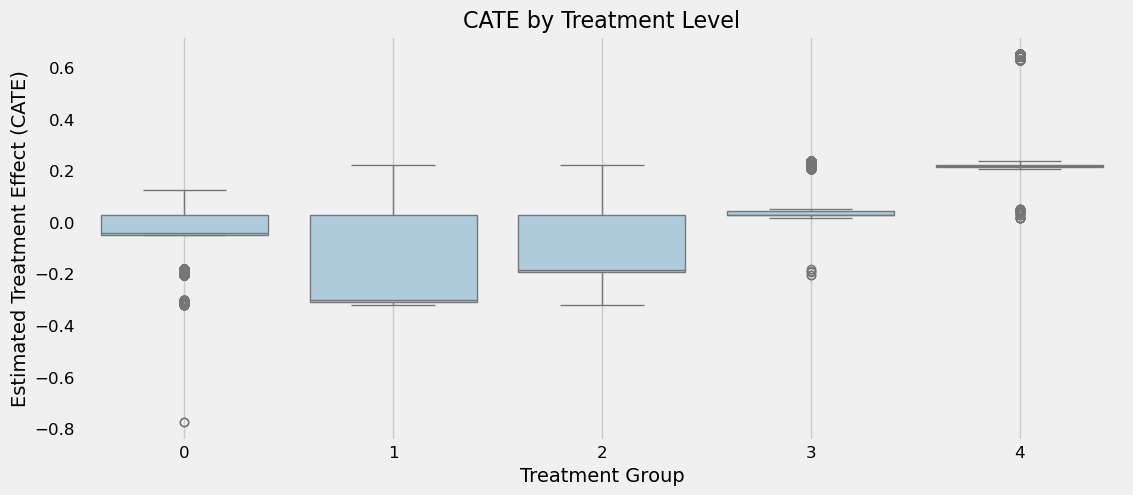

In [ ]:
# CATE vs. experience level

plt.figure(figsize=(12, 5))
sns.boxplot(x=df_encoded[treatment_col], y=df_encoded["tau_hat"])
plt.xlabel("Treatment Group")
plt.ylabel("Estimated Treatment Effect (CATE)")
plt.title("CATE by Treatment Level")
plt.grid()
plt.show()

- Treatment Groups 0, 1, and 2 have relatively stable and small CATE values, meaning the treatment had little impact.
- Treatment Group 3 experienced a wider range of effects, with a median slightly below zero, meaning some benefited while others experienced a decline.
- Treatment Group 4 shows the most variation with potentially strong positive effects, suggesting this group is the most influenced by treatment.

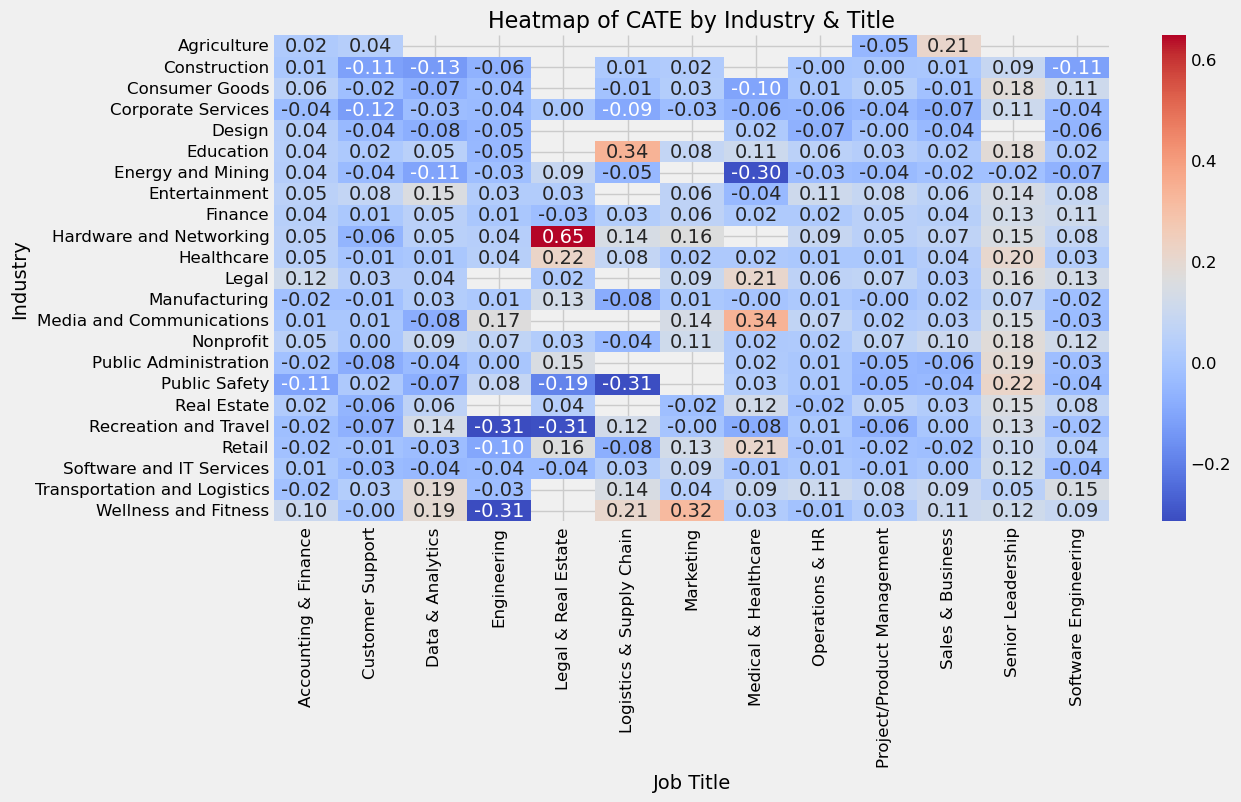

In [ ]:
# CATE by industry & title

# restore one-hot encoded labels
industry_cols = [col for col in df_encoded.columns if col.startswith("industry_")]
title_cols = [col for col in df_encoded.columns if col.startswith("title_family_")]

df_encoded["industry"] = df_encoded[industry_cols].idxmax(axis=1).str.replace("industry_", "")
df_encoded["title_family"] = df_encoded[title_cols].idxmax(axis=1).str.replace("title_family_", "")

heatmap_data = df_encoded.pivot_table(values="tau_hat", index="industry", columns="title_family", aggfunc="mean")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.xlabel("Job Title")
plt.ylabel("Industry")
plt.title("Heatmap of CATE by Industry & Title")
plt.xticks(rotation=90)
plt.show()

The overall dominance of blue shades in the heatmap suggests that the estimated CATE are predominantly negative or close to zero across most industry and job title combinations. This indicates that the treatment does not consistently increase application rates and, in many cases, may even have a slight deterrent effect. But I would more subscribe to that the model performs poorly

### Sensitivity Analysis (Robustness Checks)

In [ ]:
model = CausalModel(
    data=df_encoded,
    treatment = treatment_col,
    outcome="tau_hat",
    common_causes=dummy_confounders
)

identified_estimand = model.identify_effect()
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

# random common cause
res_random = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="random_common_cause",
    show_progress_bar=True
)

print("Refutation using Random Common Cause:")
print(res_random)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refutation using Random Common Cause:
Refute: Add a random common cause
Estimated effect:0.07315654101107721
New effect:0.07315635756224806
p value:0.98



In [ ]:
# placebo test
res_placebo = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name = "placebo_treatment_refuter",
    placebo_type = "permute",
    show_progress_bar = True
)
print("Refutation using Placebo Treatment:")
print(res_placebo)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refutation using Placebo Treatment:
Refute: Use a Placebo Treatment
Estimated effect:0.07315654101107721
New effect:3.1402564460144155e-05
p value:0.98



In [ ]:
# data subset test
res_subset = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name = "data_subset_refuter",
    subset_fraction = 0.9,  # threshold = 90%
    show_progress_bar = True
)
print("Refutation using Data Subset:")
print(res_subset)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refutation using Data Subset:
Refute: Use a subset of data
Estimated effect:0.07315654101107721
New effect:0.07318060120476405
p value:1.0



## Conclusion

#### Limitations

- Self-reported Salary Data: Potential inaccuracies and misclassification.
- Temporal Limitations: Monthly updates may not capture long-term trends.
0 Industry-Specific Variations: Findings may not generalize across all sectors.

####  Threat of Validity
- SOO data: many unobserved factors could affect the job application and salary.
- Selection bias: Some jobs may always have benefits or high salaries.

##### Extensions
- For job seekers models, it only provide general trend, consider Stratify by Experience/Location, like For me it maybe more valuable to only focus on entry-level roles, and Industry choice has a larger salary impact.
- Industry-Specific Analysis: Future research should examine salary determinants within specific fields rather than treating all industries equally.